# Семинар 2. Преобразование количественных данных

In [130]:
# импортируем библиотеки
import numpy as np
import scipy.stats as st
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

# установим размер и стиль Seaborn для последующих графиков
sns.set_theme(rc = {'figure.figsize' : (8, 5)})

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')


## 1. Обсуждение методов 

### Подготовка данных

In [14]:
# возьмем признак LSTAT (процент населения с низким социальным статусом)
# и целевую переменную MEDV (медианная стоимость жилья)
boston = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')[['age','lstat', 'medv']]

In [15]:
boston.head()

,age,lstat,medv
0,65.2,4.98,24.0
1,78.9,9.14,21.6
2,61.1,4.03,34.7
3,45.8,2.94,33.4
4,54.2,5.33,36.2


In [16]:
# посмотрим на основные статистические показатели
stats = boston.describe()

#Добавим асимметрию
stats.loc['skew'] = boston.skew()
# и эксцесс
stats.loc['kurtosis'] =  boston.kurtosis()
stats

,age,lstat,medv
count,506.000000,506.000000,506.000000
mean,68.574901,12.653063,22.532806
std,28.148861,7.141062,9.197104
min,2.900000,1.730000,5.000000
25%,45.025000,6.950000,17.025000
50%,77.500000,11.360000,21.200000
75%,94.075000,16.955000,25.000000
max,100.000000,37.970000,50.000000
skew,-0.598963,0.906460,1.108098
kurtosis,-0.967716,0.493240,1.495197


<Axes: ylabel='Density'>

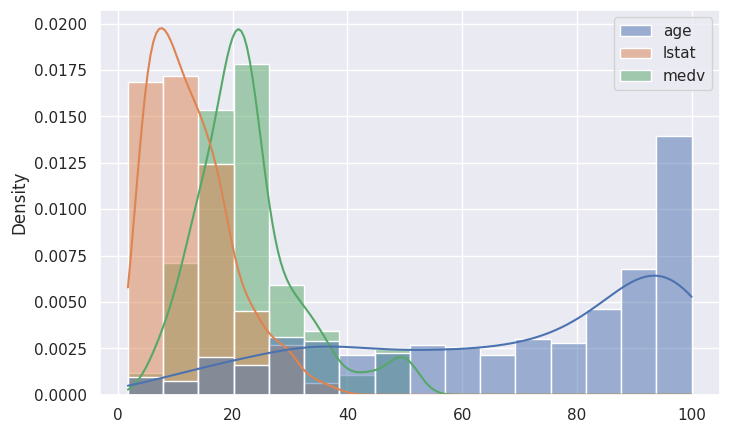

In [17]:
# посмотрим на данные с помощью гистограммы
sns.histplot(boston, kde=True,stat = 'density')
# boston.hist(bins = 15, figsize = (10, 5));

Посмотрим, как сильно отличается наше распределение от нормального.
Для этого построим **Q-Q диаграму** - график сопоставляющий квантилям теоретического распределения (нормального в нашем случае) - квантили наблюдаемого распределения.

Нулевой квантиль соответствует медиане ($q_{0.5}$), $1$ - верхнему квартилю ($q_{0.75}$), $-1$ - нижнему кварилю ($q_{0.25}$)

Подробнее о Q-Q диаграмме читайте здесь: [Q-Q Plots. От чайника до профессионала за один гайд // Хабр, 2021](https://habr.com/ru/articles/578754/)

Чем сильнее отклоняется график от прямой, тем сильнее отличие от теоретического распределения.

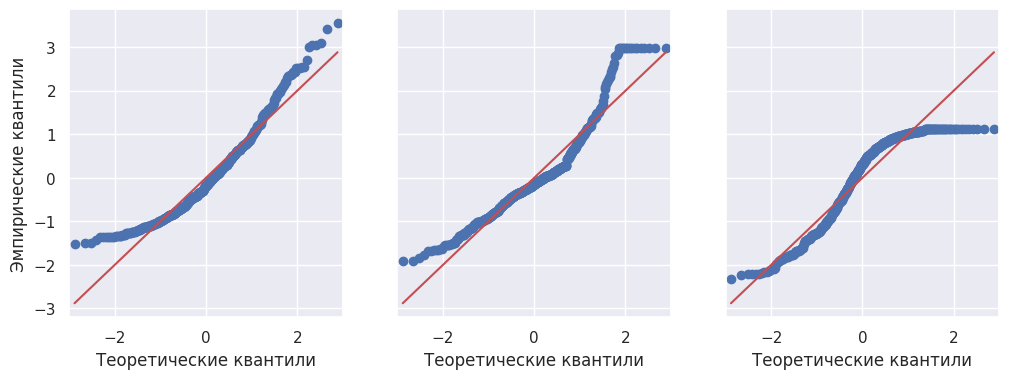

In [18]:

fig, axs = plt.subplots(
    ncols=3, # число колонок
    sharey=True, # Общая ось Y
    figsize = (12,4)
)

sm.qqplot(boston['lstat'], dist=st.norm, line='s', fit=True, ax=axs[0])
sm.qqplot(boston['medv'], dist=st.norm, line='s', fit=True, ax=axs[1])
sm.qqplot(boston['age'], dist=st.norm, line='s', fit=True, ax=axs[2])
for ax in axs:
    ax.set_xlabel("Теоретические квантили")
    ax.set_ylabel("")
axs[0].set_ylabel("Эмпирические квантили")

plt.show();


 Видим, что распределеления обеих наблюдаемых величин  отличаются от нормального

Однако, именно нормальное распределение хорошо изучено. Большинство статистических методов замечательно работает с нормальными данными. Более того, для многие модели ML предполагают нормально распределенные данные.


**Наша цель:** преобразовать данные так, чтобы распределение было как можно ближе к нормальному.

**Путь решения:** Выполнить преобразование данных так, чтобы выровнять Q-Q график.

### Виды преобразований
При обработке  данных применяются два типа преобразований:
- *Масштабирование* - линейное преобразование - не меняет структуры распределения, но позволяет привести параметры распределения к эталонным, например $N(\mu,\sigma) \to N(0,1)$
- *Нелинейные преобразования* - меняют форму распределения и используются для приближения эмпирического распределения к требуемому теоретическому.

Рассмотрим пример:
- В качестве масштабирования возьмем преобразование стандартизации 
$ X' = \frac{X-\bar(X)}{s_X}$
где $\bar{X}$ - выборочная средняя, $s_X$ - выборочное среднее квадратическое отклонение.

- В качестве нелинейного преобразования - преобразование Бокса-Кокса.


In [19]:
# Загрузим функции преобразований:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer 

std_scaler = StandardScaler()
bc_transformer = PowerTransformer(method = 'box-cox', standardize=True)

# Выполним линейное преобразование
X = boston[['lstat']]
X['std-scale'] = std_scaler.fit_transform(X[['lstat']])
X['box-cox-transform'] = bc_transformer.fit_transform(X[['lstat']])


/tmp/ipykernel_4250/3140388924.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['std-scale'] = std_scaler.fit_transform(X[['lstat']])


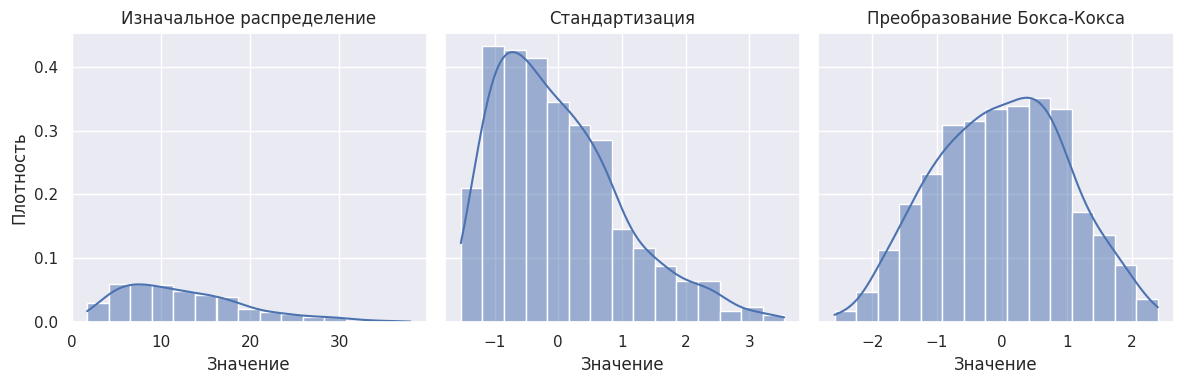

In [20]:
# создадим сетку подграфиков 1 x 3
fig, axs = plt.subplots(
    ncols=3, # число колонок
    sharey=True, # Общая ось Y
    figsize = (12,4)
)

# на первом графике разместим изначальное распределение
sns.histplot(data = X, x = 'lstat', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[0]).set(title = 'Изначальное распределение', xlabel = 'Значение', ylabel = 'Плотность')
# на втором - данные после стандартизации
sns.histplot(data = X, x = 'std-scale', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[1]).set(title = 'Стандартизация',xlabel = 'Значение')
# и на третьем графике покажем преобразование Бокса-Кокса
sns.histplot(data = X, x = 'box-cox-transform', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[2]).set(title = 'Преобразование Бокса-Кокса',xlabel = 'Значение')
plt.tight_layout()
plt.show()

- В первом случае форма распределения сохранилась, изменился только масштаб. 
- Во втором случае, изменилась сама структура распределения, то есть соотношение расстояний между точками.

#### Добавление выбросов

Выбросы очень сильно влияют на качество данных. Для того чтобы посмотреть, как рассматриемые нами инструменты справляются с выбросами, добавим несколько сильно отличающихся от общей массы наблюдений.

In [21]:
# создадим два отличающихся наблюдения
outliers = pd.DataFrame({
    'lstat': [45, 50],
    'medv': [70, 72],
    'age': [1, 1],
    })

# добавим их в исходный датафрейм
boston_outlier = pd.concat([boston, outliers], ignore_index = True)

# посмотрим на размерность нового датафрейма
boston_outlier.shape

(508, 3)

In [22]:
boston_outlier

,age,lstat,medv
0,65.2,4.98,24.0
1,78.9,9.14,21.6
2,61.1,4.03,34.7
3,45.8,2.94,33.4
4,54.2,5.33,36.2
...,...,...,...
503,91.0,5.64,23.9
504,89.3,6.48,22.0
505,80.8,7.88,11.9
506,1.0,45.00,70.0


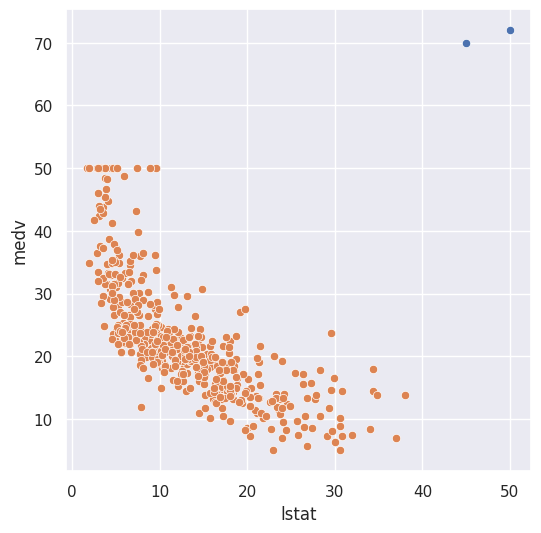

In [23]:
# убедимся, что наблюдения добавились
fig, axs = plt.subplots(1, 1, figsize = (6,6))

sns.scatterplot(data = boston_outlier, x = 'lstat', y = 'medv', ax = axs)
sns.scatterplot(data = boston, x = 'lstat', y = 'medv', ax = axs)
plt.plot();
# видим синие выбросы


### Линейные преобразования

#### Стандартизация

Если данные удовлетворяют нормальному или близкому к нормальному распределению, то имеет смысл прибегнуть к стандартизации: то есть приведению к нулевому среднему значению и единичному среднему квадратичному отклонению.

Это легко сделать по формуле 
$$ 
X' = \frac{X-\bar{X}}{s_X}
$$

Или воспользоваться классом `StandardScaler` из `sklearn.preprocessing`.

**ЗАДАНИЕ** - Реализуйте стандартизацйию данных из `boston_outlier` вручную и с помощью `StandardScaler`. 

- Убедитесь в том, что данные одинаковы
- Сохраните данные в `boston_outlier_scaled`
- Постройте графики и убедитесь, что выбросы сохранились. А что произошло с данными?
- Выполните обратное преобразование, сохранив результат в `boston_outlier_inverse`. (Вернуть исходный масштаб можно как по формуле, так и с помощью метода `.inverse_transform()` класса `StandardScaler`).
- Будут ли данные одинаковы?

In [24]:
# 1. Ручная стандартизация
means = boston_outlier.mean()
stds = boston_outlier.std(ddof=0)  # Используем ddof=0 для совпадения с StandardScaler
boston_outlier_scaled_manual = (boston_outlier - means) / stds

# 2. Стандартизация с помощью StandardScaler
scaler = StandardScaler()
scaled_sklearn = scaler.fit_transform(boston_outlier)
boston_outlier_scaled_sklearn = pd.DataFrame(scaled_sklearn, columns=boston_outlier.columns)

# 3. Сравнение результатов
print("Различия между ручной и автоматической стандартизацией:")
diff = (boston_outlier_scaled_manual - boston_outlier_scaled_sklearn).abs().max().max()
print(f"Максимальное различие: {diff:.6f}")  # Ожидаем значения близкие к нулю

# 4. Сохранение стандартизованных данных
boston_outlier_scaled = boston_outlier_scaled_sklearn

Различия между ручной и автоматической стандартизацией:
Максимальное различие: 0.000000


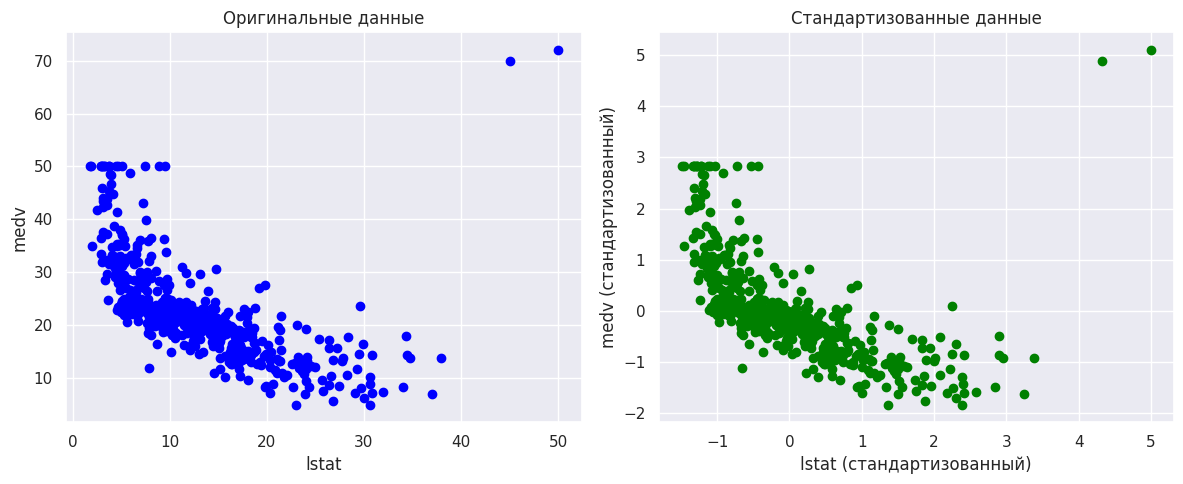

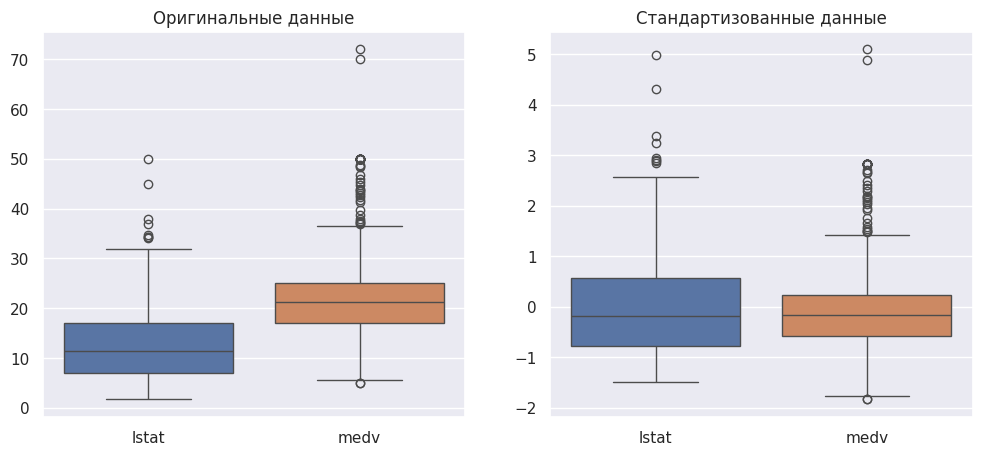

In [25]:
# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Оригинальные данные
axes[0].scatter(boston_outlier['lstat'], boston_outlier['medv'], c='blue', label='Данные')
axes[0].set_title('Оригинальные данные')
axes[0].set_xlabel('lstat')
axes[0].set_ylabel('medv')

# Стандартизованные данные
axes[1].scatter(boston_outlier_scaled['lstat'], boston_outlier_scaled['medv'], c='green', label='Стандартизованные')
axes[1].set_title('Стандартизованные данные')
axes[1].set_xlabel('lstat (стандартизованный)')
axes[1].set_ylabel('medv (стандартизованный)')

plt.tight_layout()
plt.show()

# Boxplot для анализа выбросов
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=boston_outlier[['lstat', 'medv']], ax=axes[0]).set(title='Оригинальные данные')
sns.boxplot(data=boston_outlier_scaled[['lstat', 'medv']], ax=axes[1]).set(title='Стандартизованные данные')
plt.show()

Различия после обратного преобразования:
Максимальное различие: 0.000000


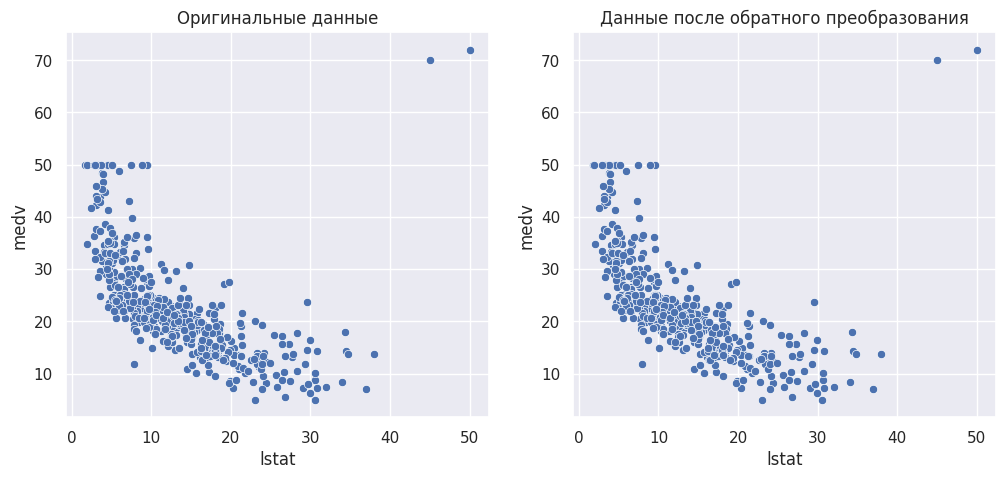

In [26]:
# Обратное преобразование
boston_outlier_inverse = pd.DataFrame(scaler.inverse_transform(boston_outlier_scaled), columns=boston_outlier.columns)

# Проверка совпадения с исходными данными
print("Различия после обратного преобразования:")
diff_inverse = (boston_outlier - boston_outlier_inverse).abs().max().max()
print(f"Максимальное различие: {diff_inverse:.6f}")  # Ожидаем значения близкие к нулю

# Визуальное сравнение
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=boston_outlier, x='lstat', y='medv', ax=axes[0]).set(title='Оригинальные данные')
sns.scatterplot(data=boston_outlier_inverse, x='lstat', y='medv', ax=axes[1]).set(title='Данные после обратного преобразования')
plt.show()

Ответы на вопросы: 

1. Совпадают ли данные после ручной и автоматической стандартизации? <br>
    Да, различия незначительны (на уровне 10−15) из-за численных ошибок. 

2. Сохранились ли выбросы после стандартизации? <br>
    Да, выбросы остались, так как стандартизация не влияет на относительное положение точек. 

3. Что произошло с данными после стандартизации? <br>
    Все признаки были приведены к среднему 0 и стандартному отклонению 1. Масштаб данных изменился, но структура (включая выбросы) сохранилась. 

4. Будут ли данные одинаковы после обратного преобразования? <br>
    Да, с точностью до численных ошибок. Различия незначительны и не влияют на анализ.

**Замечание:**
Если при разработке моделей ML мы отмасштабируем все данные (обучающую и тестовую выборки), то получим утечку информации о тестовой выборке.

Поэтому, алгоритм масштабирования, как впрочем и других преобразований следующий:
1. Рассчитать параметры преобразования (среднее и СКО) для обучающей выборки
2. Отмасштабировать обучающую выборку
3. Обучить  модель
4. **Использовать ранее рассчитанные параметры** (среднее и СКО) для масштабирования тестовых данных
5. Сделать прогноз на отмасштабированных тестовых данных.
6. Оценить качество модели.

#### Приведение к диапазону 

Приведение к диапазону  используется, если требуется работать с данными из некоторого отрезка. Например, теоремы об апроксимации (функций нейросетями) доказаны для входных данных из отрезка $[0;1]$.

Приведение данных к отрезку $[0;1]$ можно выполнить по формуле:
$$
    x' = \frac{x-x_{\min}}{x_{\max}-x_{\min}}
$$

Это преобразование реализуется с помощью класса from  import `MinMaxScaler` из `sklearn.preprocessing`.


Проблема преобразования приведения к диапазону - чувствительность к выбросам. Их наличие существенно снижает вариацию данных.

In [27]:
# импортируем класс MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# создаем объект этого класса,
# в параметре feature_range оставим диапазон по умолчанию
minmax = MinMaxScaler(feature_range = (0, 1))

# применим метод .fit() и
minmax.fit(boston)

# найдем минимальные и максимальные значения
minmax.data_min_, minmax.data_max_

(array([2.9 , 1.73, 5.  ]), array([100.  ,  37.97,  50.  ]))

In [28]:
# приведем данные без выбросов (достаточно метода .transform())
boston_scaled = minmax.transform(boston)

# и с выбросами к заданному диапазону
boston_outlier_scaled = minmax.fit_transform(boston_outlier)

# преобразуем результаты в датафрейм
boston_scaled = pd.DataFrame(boston_scaled, columns = boston.columns)
boston_outlier_scaled = pd.DataFrame(boston_outlier_scaled, columns = boston.columns)

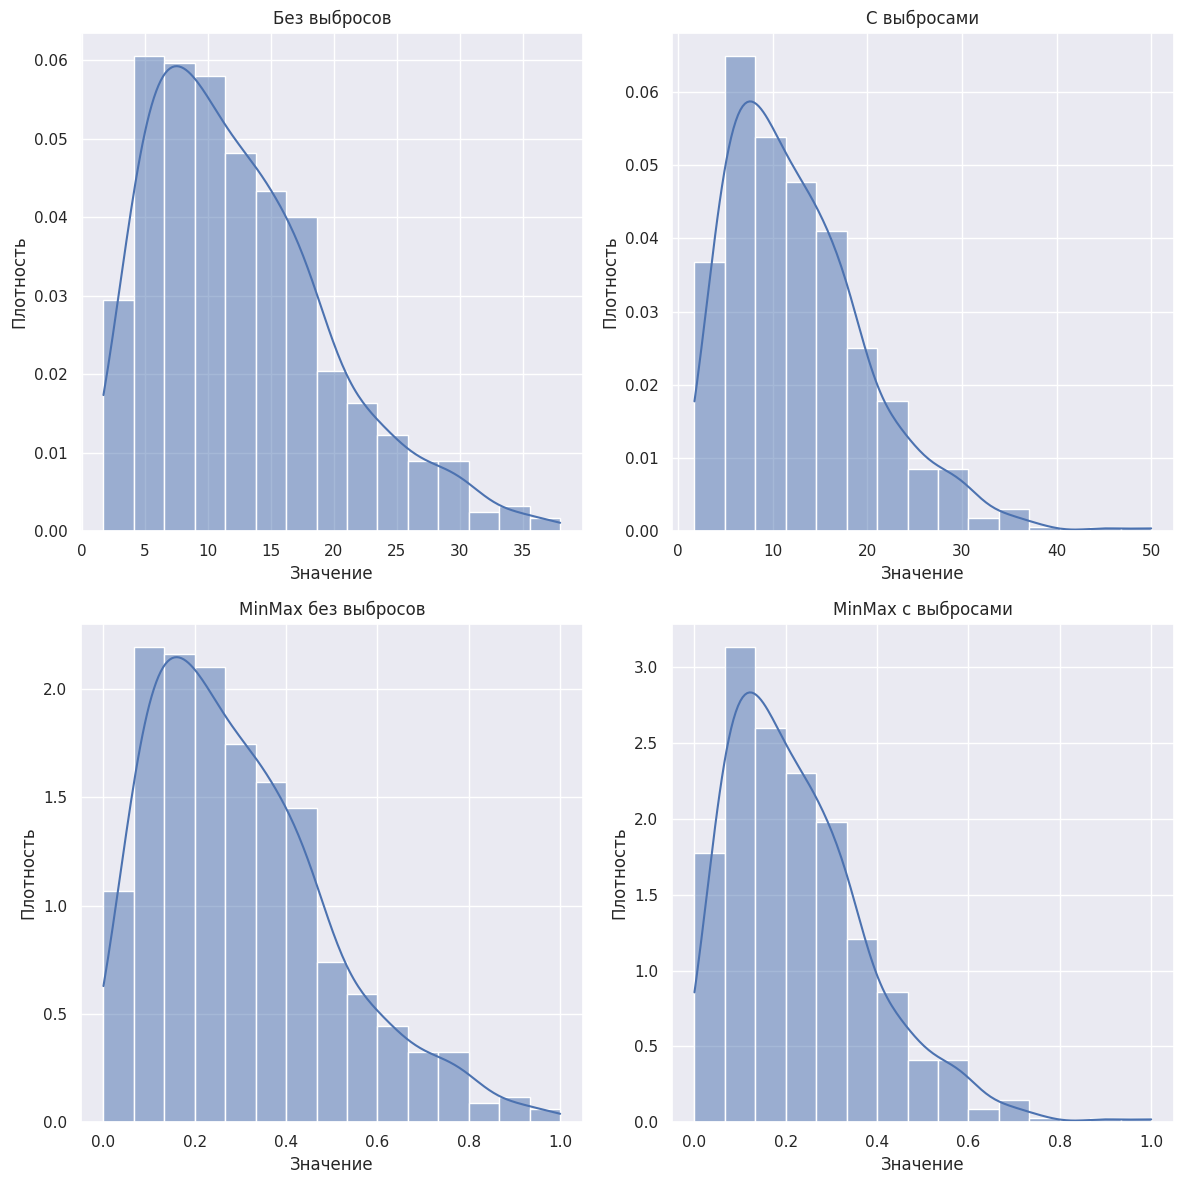

In [17]:
# построим точечные диаграммы
fig, axs = plt.subplots(
    nrows=2, # число строк
    ncols=2, # число колонок
    figsize = (12,12),
)
sns.histplot(data = boston, x = 'lstat', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[0,0]).set(title = 'Без выбросов',xlabel = 'Значение',ylabel = 'Плотность')
sns.histplot(data = boston_outlier, x = 'lstat', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[0,1]).set(title = 'C выбросами',xlabel = 'Значение',ylabel = 'Плотность')
sns.histplot(data = boston_scaled, x = 'lstat', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[1,0]).set(title = 'MinMax без выбросов',xlabel = 'Значение',ylabel = 'Плотность')
sns.histplot(data = boston_outlier_scaled, x = 'lstat', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[1,1]).set(title = 'MinMax с выбросами',xlabel = 'Значение',ylabel = 'Плотность')
plt.tight_layout()
plt.show();


#### Робастое масштабирование

Выполним масштабирование относительно нижнего и верхнего квартилей
$$
x' = \frac{x-Q_{I}}{Q_{III}-Q_{I}}
$$

Такое преобразование более устойчиво к выбросам.
Может быть реализовано с помощью `RobustScaler` из `sklearn.preprocessing`

**Задание:** Поэкспериментируйте с робастым масштабированием сами.

In [35]:
from sklearn.preprocessing import RobustScaler

# Инициализация и применение RobustScaler
robust_scaler = RobustScaler()
scaled_robust = robust_scaler.fit_transform(boston_outlier)

# Сохранение результатов в DataFrame
boston_outlier_robust = pd.DataFrame(scaled_robust, columns=boston_outlier.columns)

# Параметры масштабирования
print("Медианы признаков:")
print(robust_scaler.center_)
print("\nИнтерквартильный размах (IQR):")
print(robust_scaler.scale_)

Медианы признаков:
[77.15  11.395 21.2  ]

Интерквартильный размах (IQR):
[49.8    10.1025  7.925 ]


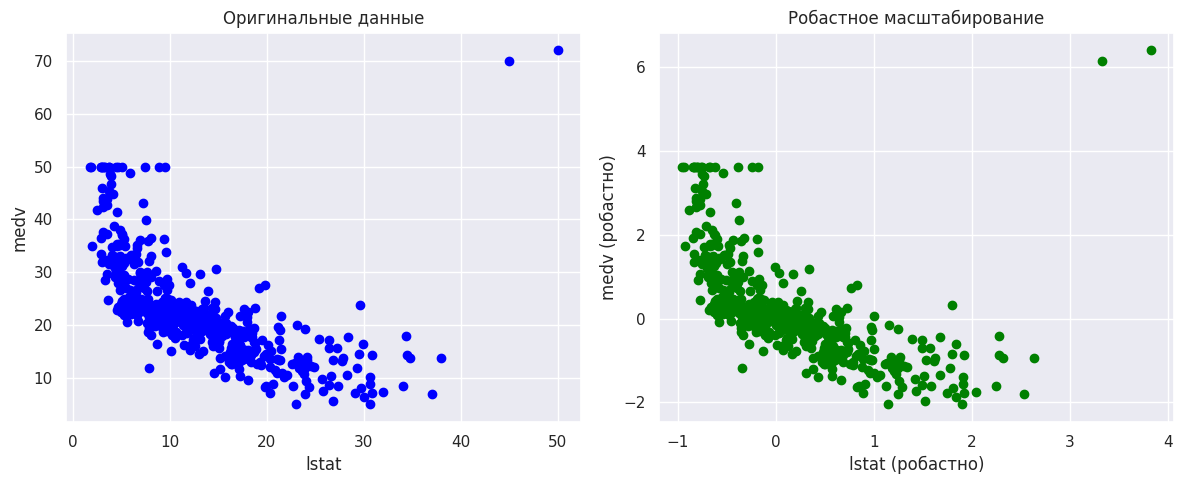

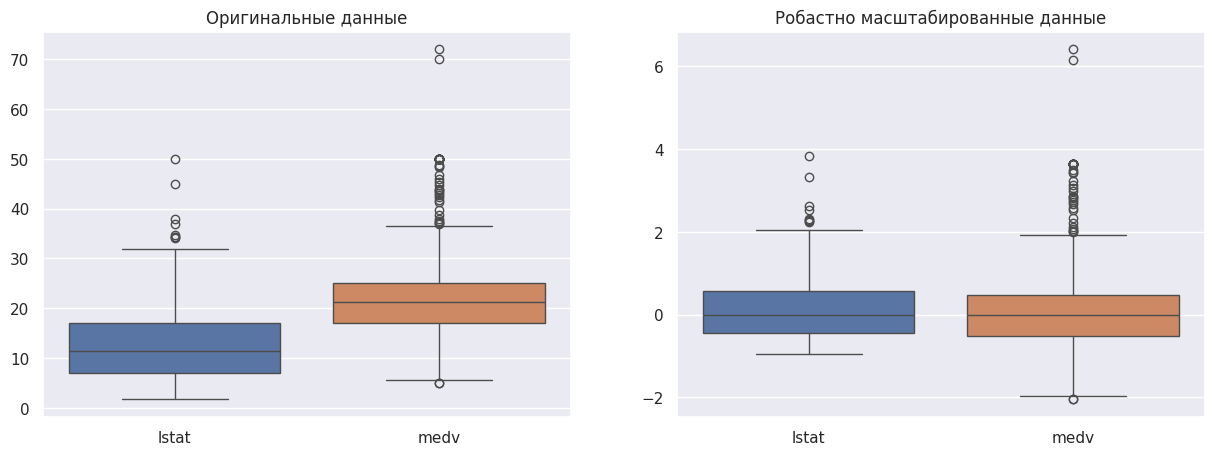

In [40]:
# Визуализация до и после робастного масштабирования
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Оригинальные данные
axes[0].scatter(boston_outlier['lstat'], boston_outlier['medv'], c='blue', label='Данные')
axes[0].set_title('Оригинальные данные')
axes[0].set_xlabel('lstat')
axes[0].set_ylabel('medv')

# Робастно масштабированные данные
axes[1].scatter(boston_outlier_robust['lstat'], boston_outlier_robust['medv'], c='green', label='Робастное масштабирование')
axes[1].set_title('Робастное масштабирование')
axes[1].set_xlabel('lstat (робастно)')
axes[1].set_ylabel('medv (робастно)')

plt.tight_layout()
plt.show()

# Boxplot для анализа выбросов
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=boston_outlier[['lstat', 'medv']], ax=axes[0]).set(title='Оригинальные данные')
sns.boxplot(data=boston_outlier_robust[['lstat', 'medv']], ax=axes[1]).set(title='Робастно масштабированные данные')
plt.show()

### Нелинейные преобразования

#### Логарифмическое преобразование
$$
X' = \ln X
$$
* В результате преобразования: 
    - расстояние между небольшими значениями увеличивается;
    - расстояние между большими значениями - уменьшается.
* Применяется с целью компенсации **положительной асимметрии** распределения. Оно делает скошенное вправо распределение более симметричным и, следовательно, более близким к нормальному. 
* Логарифмическое преобразование легко интерпретировать. 
Уменьшим $X$ на 15% и вычислим его логарифм. $\ln(0.85\cdot X) = \ln(0.85)+ \ln X = -0.163 + X'$.
Таким образом, снижение на $0.163$ преобразованного значения свидетельствует о снижении на 15% в исходных данных вне зависимости от их масштаба.

* К сожалению, преобразование возможно только для положительных исходных значений.



In [41]:
X = boston[['lstat']]
X['log_trans'] = np.log(X['lstat'])

/tmp/ipykernel_4250/4165858177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_trans'] = np.log(X['lstat'])


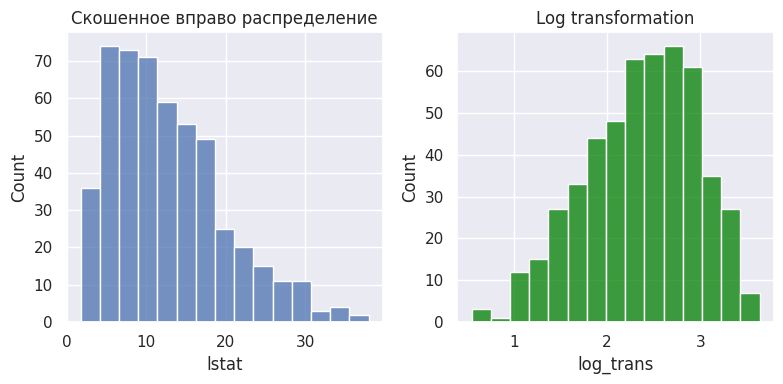

In [42]:
fig, axs = plt.subplots(
    nrows = 1, 
    ncols = 2, 
    figsize = (8,4)
)


sns.histplot(x = X['lstat'], bins = 15, ax = axs[0]).set(title='Скошенное вправо распределение')

sns.histplot(x = X['log_trans'],
             bins = 15, color = 'green',
            ax = axs[1]).set(title = 'Log transformation')

plt.tight_layout()
plt.show();

In [43]:
# рассчитаем ассиметрию до и после преобразования
X.skew()


lstat        0.906460
log_trans   -0.320232
dtype: float64

In [44]:
# рассчитаем коэффициент эксцесса до и после преобразования
X.kurtosis()

lstat        0.493240
log_trans   -0.431477
dtype: float64

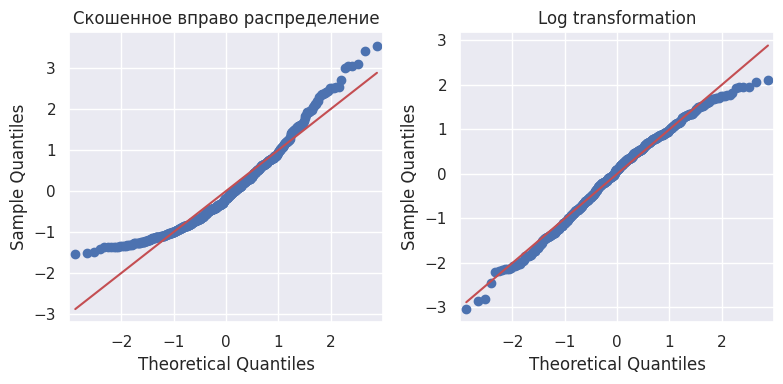

In [45]:
# построим Q-Q диаграмы нормальной вероятности
from scipy.stats import probplot

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sm.qqplot(X['lstat'], dist=st.norm, line='s', fit=True, ax=axs[0])
axs[0].set_title('Скошенное вправо распределение')

sm.qqplot(X['log_trans'], dist=st.norm, line='s', fit=True, ax=axs[1])
axs[1].set_title('Log transformation')

plt.tight_layout()
plt.show();

# и визуально оценим, приблизилось ли распределение к нормальному.

**Задание:** Сделайте то же самое над датасетом с выбросами.

Как влияет наличие выборосов на качество выравнивания асимметрии?


In [46]:
X_ol = boston_outlier[['lstat']]
X_ol['log_trans'] = np.log(X_ol['lstat'])

/tmp/ipykernel_4250/437092827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ol['log_trans'] = np.log(X_ol['lstat'])


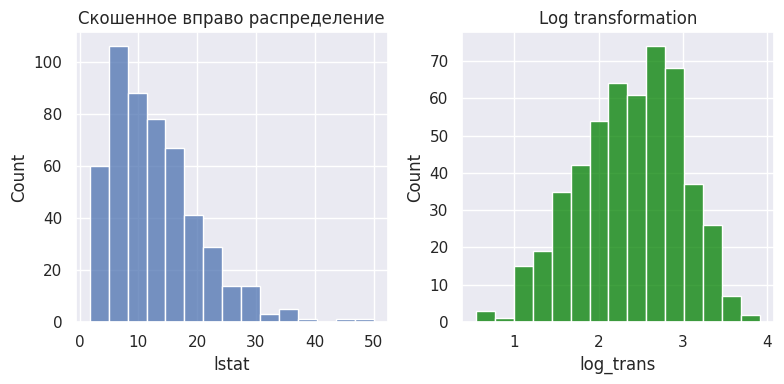

In [47]:
fig, axs = plt.subplots(
    nrows = 1, 
    ncols = 2, 
    figsize = (8,4)
)


sns.histplot(x = X_ol['lstat'], bins = 15, ax = axs[0]).set(title='Скошенное вправо распределение')

sns.histplot(x = X_ol['log_trans'],
             bins = 15, color = 'green',
            ax = axs[1]).set(title = 'Log transformation')

plt.tight_layout()
plt.show();

In [48]:
# рассчитаем ассиметрию до и после преобразования
X_ol.skew()

lstat        1.148425
log_trans   -0.279995
dtype: float64

In [49]:
# рассчитаем коэффициент эксцесса до и после преобразования
X_ol.kurtosis()

lstat        1.801421
log_trans   -0.386912
dtype: float64

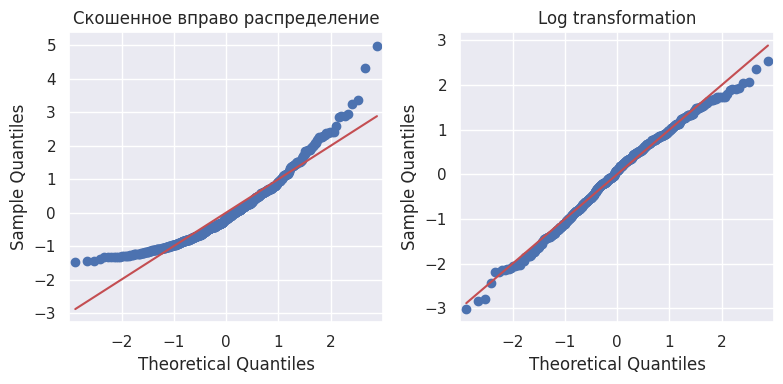

In [50]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sm.qqplot(X_ol['lstat'], dist=st.norm, line='s', fit=True, ax=axs[0])
axs[0].set_title('Скошенное вправо распределение')

sm.qqplot(X_ol['log_trans'], dist=st.norm, line='s', fit=True, ax=axs[1])
axs[1].set_title('Log transformation')

plt.tight_layout()
plt.show();

# и визуально оценим, приблизилось ли распределение к нормальному.

Логарифмическое преобразование способно корректировать положительную асимметрию. 
Однако, для правой асимметрии оно совершенно не применимо.

Рассмотрим, например, возраст продаваемых квартир (поле age)

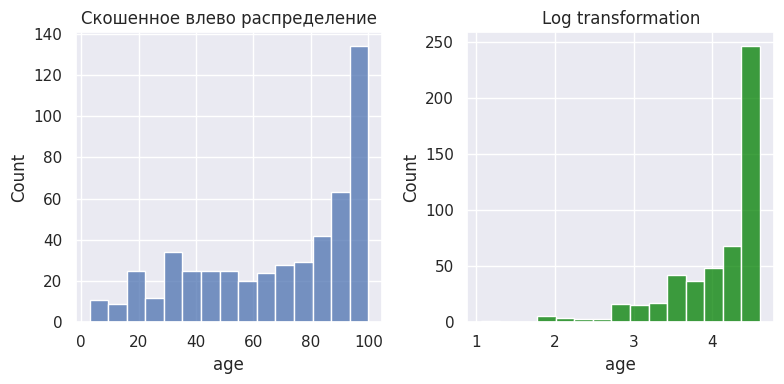

In [25]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sns.histplot(x = boston['age'], bins = 15, ax = axs[0])
axs[0].set_title('Скошенное влево распределение')

sns.histplot(x = np.log(boston['age']),
             bins = 15, color = 'green',
            ax = axs[1])
axs[1].set_title('Log transformation')

plt.tight_layout()
plt.show()

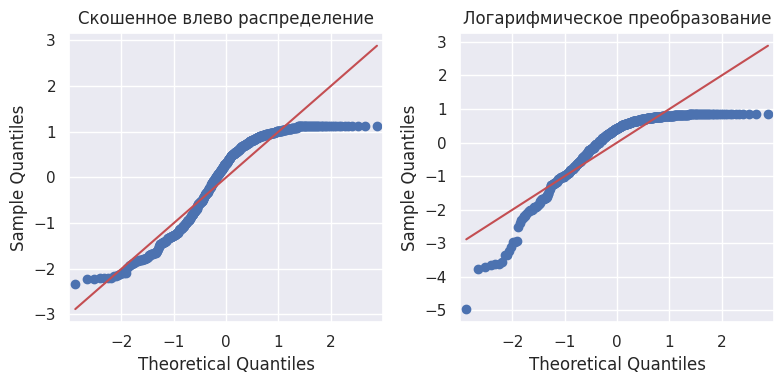

In [26]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sm.qqplot(boston['age'], dist=st.norm, line='s', fit=True, ax=axs[0])
axs[0].set_title('Скошенное влево распределение')

sm.qqplot(np.log(boston['age']), dist=st.norm, line='s', fit=True, ax=axs[1])
axs[1].set_title('Логарифмическое преобразование')

plt.tight_layout()
plt.show()

#### Логарифмическое преобразование над отрицательными числами:

Если в данных встречаются отрицательные числа или нуль, то логарифмическое преобразование неприменимо.

В этом случае можно воспользоваться  преобразованием *обратного гиперболического синуса* (inverse hyperbolic sine)
$$
    x' = \mathrm{\mathop{IHS}}(x) = \ln( x+ \sqrt{x^2+1})
$$
Заметим, что это преобразование обратимо:
$$
\begin{gathered}
x' = \ln( x+ \sqrt{x^2+1})\\
(e^{x'} - x)^2 = x^2+1\\
e^{2x'}- 2e^{x'}x = 1\\
x = \frac{e^{2x'}- 1}{2e^{x'}}\\
x = \frac{1}{2} \left(e^{x'}-e^{-x'}\right)
\end{gathered}
$$

**Задание:** 
- Изобразите график функции $\mathrm{\mathop{IHS}}(x)$. Как изменяет функция расстояние между элементами в отрицательной и положительной областях?
- Попробуйте применить IHS преобразование после преобразования нормализации для полей `lstat` и `age`. 
- Есть ли качественные отличия от преобразования логарифмирования?

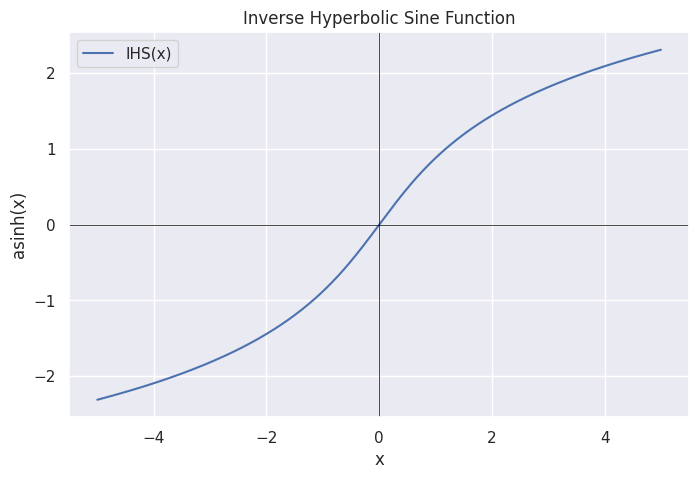

In [51]:
# Создание диапазона значений x
x = np.linspace(-5, 5, 400)
y = np.arcsinh(x)  # Функция asinh(x) = ln(x + sqrt(x² + 1))

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(x, y, label='IHS(x)')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title('Inverse Hyperbolic Sine Function')
plt.xlabel('x')
plt.ylabel('asinh(x)')
plt.legend()
plt.grid(True)
plt.show()

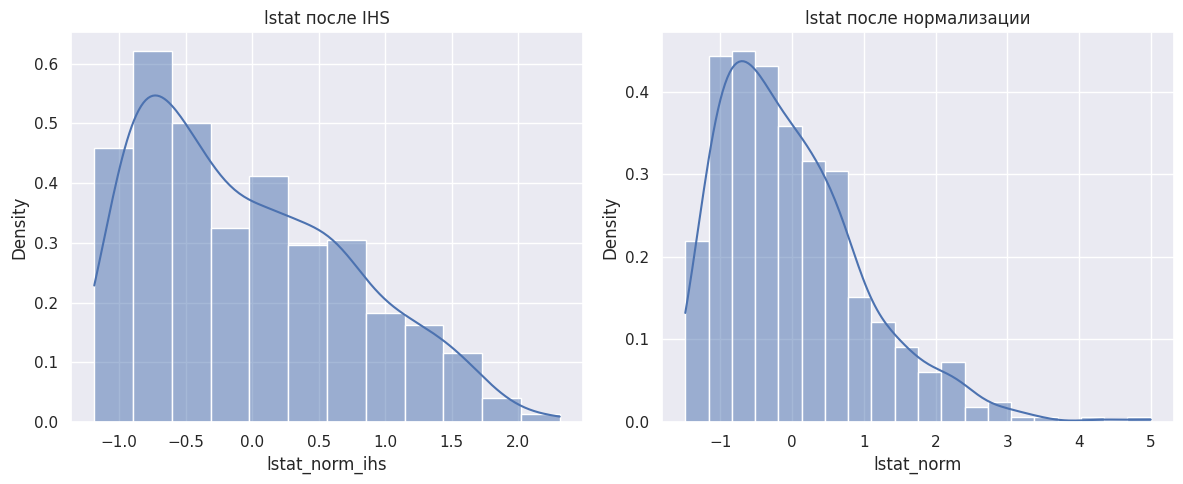

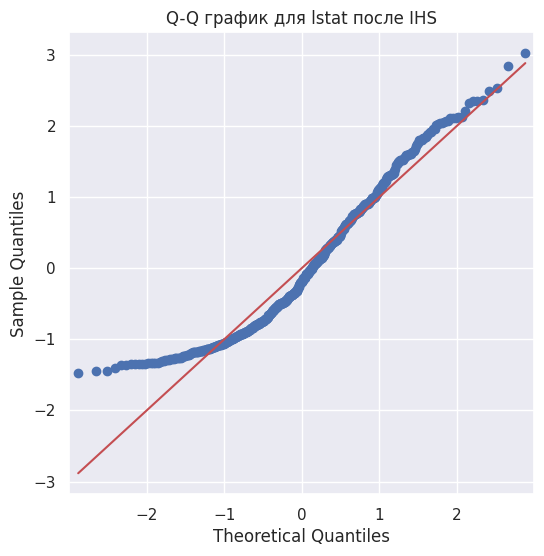

In [52]:
import statsmodels.api as sm

# Нормализация данных (StandardScaler)
scaler = StandardScaler()
boston_normalized = pd.DataFrame(
    scaler.fit_transform(boston_outlier[['lstat', 'age']]),
    columns=['lstat_norm', 'age_norm']
)

# Применение IHS к нормализованным данным
boston_ihs = pd.DataFrame()
boston_ihs['lstat_norm_ihs'] = np.arcsinh(boston_normalized['lstat_norm'])
boston_ihs['age_norm_ihs'] = np.arcsinh(boston_normalized['age_norm'])

# Визуализация распределения lstat после IHS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(boston_ihs['lstat_norm_ihs'], kde=True, stat='density', ax=axes[0]).set(title='lstat после IHS')
sns.histplot(boston_normalized['lstat_norm'], kde=True, stat='density', ax=axes[1]).set(title='lstat после нормализации')
plt.tight_layout()
plt.show()

# Q-Q график для lstat после IHS
fig, ax = plt.subplots(figsize=(6, 6))
sm.qqplot(boston_ihs['lstat_norm_ihs'], dist=st.norm, line='s', fit=True, ax=ax)
plt.title('Q-Q график для lstat после IHS')
plt.show()

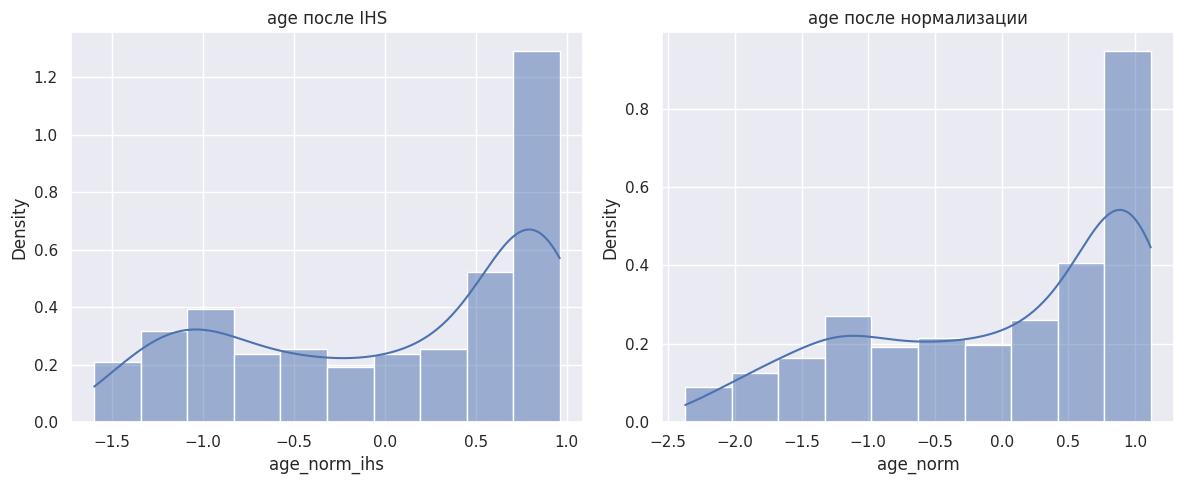

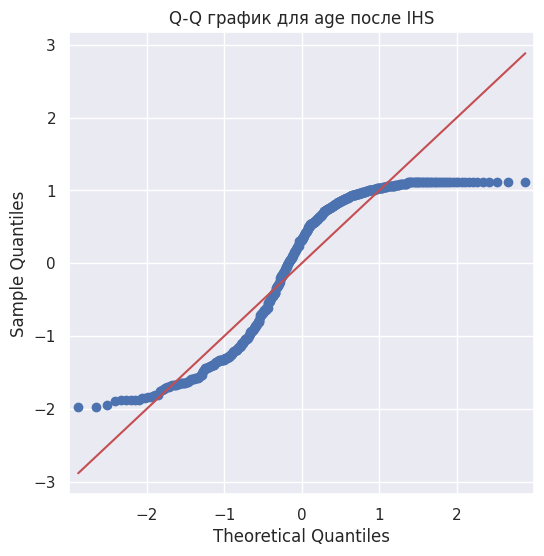

In [53]:
# Визуализация распределения age после IHS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(boston_ihs['age_norm_ihs'], kde=True, stat='density', ax=axes[0]).set(title='age после IHS')
sns.histplot(boston_normalized['age_norm'], kde=True, stat='density', ax=axes[1]).set(title='age после нормализации')
plt.tight_layout()
plt.show()

# Q-Q график для age после IHS
fig, ax = plt.subplots(figsize=(6, 6))
sm.qqplot(boston_ihs['age_norm_ihs'], dist=st.norm, line='s', fit=True, ax=ax)
plt.title('Q-Q график для age после IHS')
plt.show()

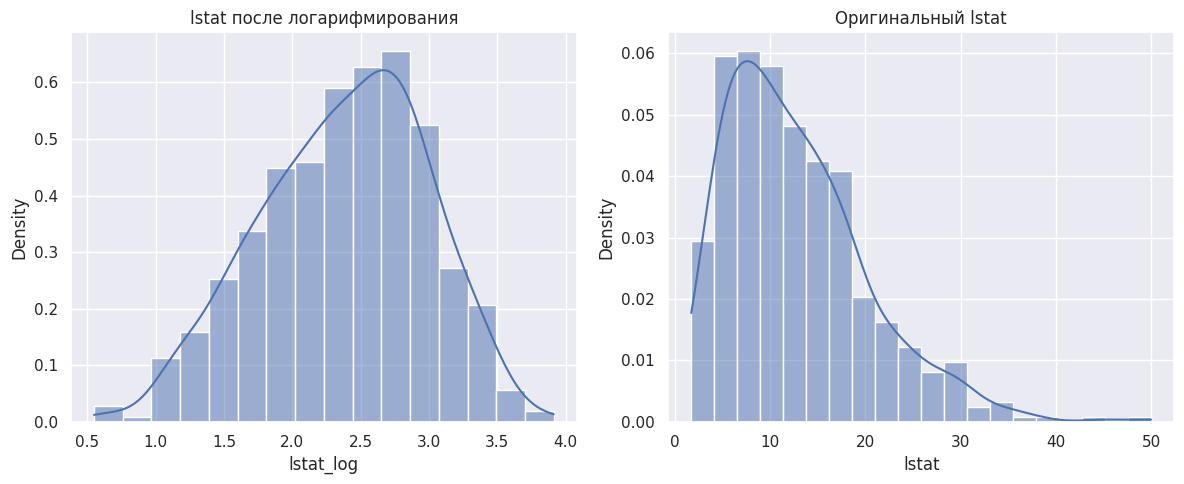

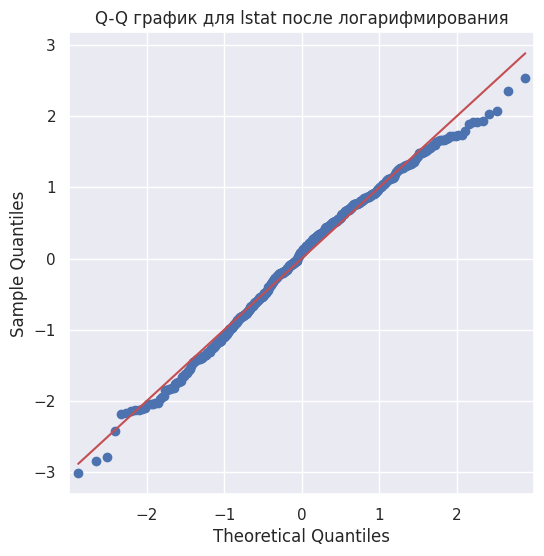

In [54]:
# Логарифмирование исходных данных (только для положительных значений)
boston_log = pd.DataFrame()
boston_log['lstat_log'] = np.log(boston_outlier['lstat'])
boston_log['age_log'] = np.log(boston_outlier['age'])

# Визуализация распределения lstat после логарифмирования
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(boston_log['lstat_log'], kde=True, stat='density', ax=axes[0]).set(title='lstat после логарифмирования')
sns.histplot(boston_outlier['lstat'], kde=True, stat='density', ax=axes[1]).set(title='Оригинальный lstat')
plt.tight_layout()
plt.show()

# Q-Q график для lstat после логарифмирования
fig, ax = plt.subplots(figsize=(6, 6))
sm.qqplot(boston_log['lstat_log'], dist=st.norm, line='s', fit=True, ax=ax)
plt.title('Q-Q график для lstat после логарифмирования')
plt.show()

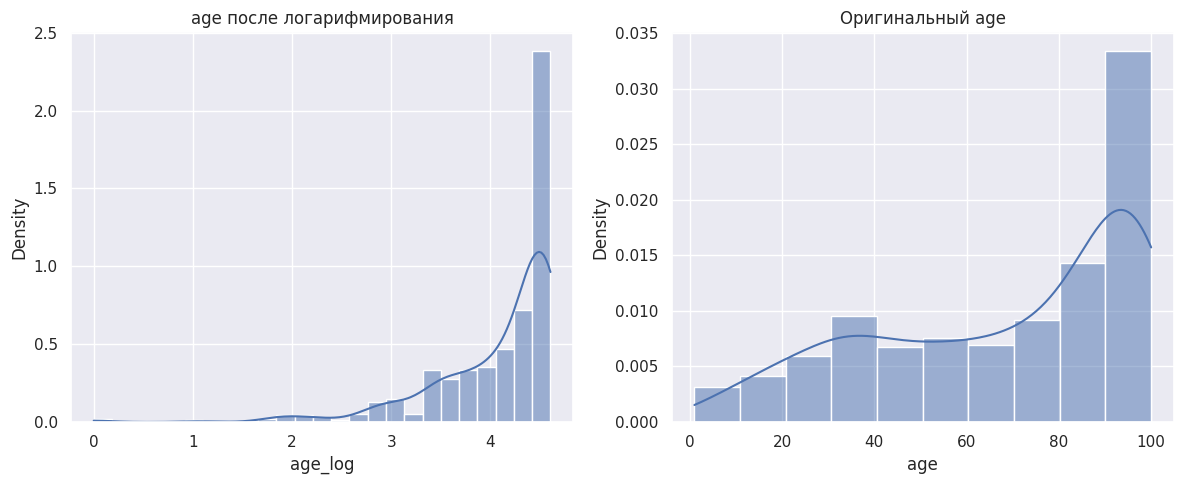

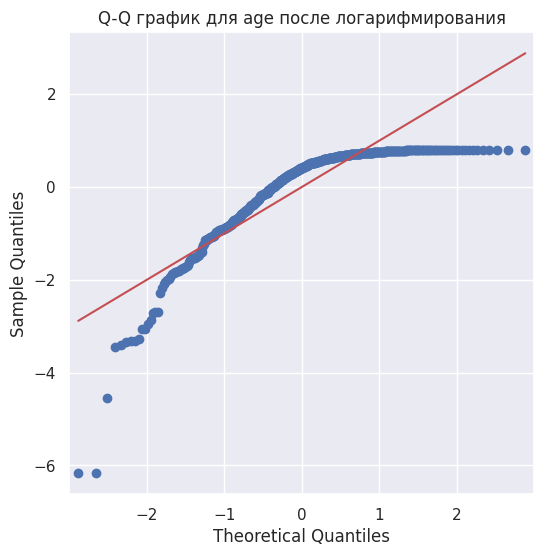

In [55]:
# Визуализация распределения age после логарифмирования
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(boston_log['age_log'], kde=True, stat='density', ax=axes[0]).set(title='age после логарифмирования')
sns.histplot(boston_outlier['age'], kde=True, stat='density', ax=axes[1]).set(title='Оригинальный age')
plt.tight_layout()
plt.show()

# Q-Q график для age после логарифмирования
fig, ax = plt.subplots(figsize=(6, 6))
sm.qqplot(boston_log['age_log'], dist=st.norm, line='s', fit=True, ax=ax)
plt.title('Q-Q график для age после логарифмирования')
plt.show()

Ответы на вопросы задания  

1. Как IHS изменяет расстояния между элементами? <br>
    Для ∣x∣<1: расстояния сохраняются (asinh(x)≈x). <br>
    Для ∣x∣>1: расстояния сжимаются (asinh(x)≈ln(2∣x∣)). <br>
    Для отрицательных x: аналогично положительным, но с отрицательным знаком.
        

2. Что произошло с данными после IHS? <br>
    Выбросы сохранились, но их влияние ослаблено. <br>
    Распределение стало более симметричным, но не полностью нормальным.
        

3. Качественные отличия от логарифмирования: <br>
    IHS применим к данным с нулями и отрицательными значениями. <br>
    Для малых x, IHS сохраняет линейную структуру, в то время как логарифмирование усиливает их влияние. <br>
    Оба метода сжимают большие значения, но IHS более универсален.



#### Преобразование Бокса-Кокса
Преобразование Бокса-Кокса (Box-Cox) является параметрическим обобщением преобразования логарифмирования:
$$
y^{(\lambda)} = \begin{cases}
\frac{y^\lambda-1}{\lambda}, & \text{ если $\lambda \neq 0$},\\ 
\ln y, & \text{ если $\lambda = 0$}.\\ 
\end{cases}
$$

* Параметр выбирается методом максимального правдоподобия (maximum likelihood method). 
* Преобразование Бокса-Кокса применимо только для положительных данных.
* При использовании преобразования Бокса-Кокса нужно сохранить параметр $\lambda$, чтобы применять его к тестовой выборке и в дальнейшем в модели. 

In [56]:
pt = PowerTransformer(method = 'box-cox')

# найдем оптимальный параметр лямбда
pt.fit(boston[['lstat']])

pt.lambdas_

array([0.22776736])

In [57]:
# преобразуем данные
bc_pt = pt.transform(boston[['lstat']])

# метод .transform() возвращает двумерный массив
bc_pt.shape

(506, 1)

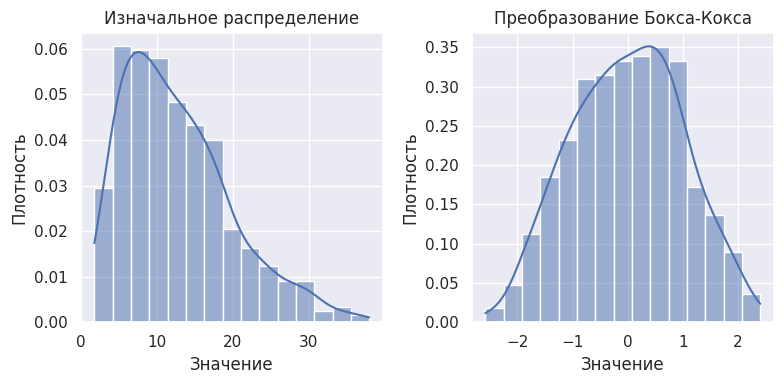

In [58]:
# сравним изначальное распределение и распределение после преобразования Бокса-Кокса
fig, axs = plt.subplots(
    nrows = 1, 
    ncols = 2, 
    figsize = (8,4)
)

sns.histplot(x = boston['lstat'], 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[0]).set(title = 'Изначальное распределение',xlabel = 'Значение',ylabel = 'Плотность')

# так как на выходе метод .transform() выдает двумерный массив,
# его необходимо преобразовать в одномерный
sns.histplot(x = bc_pt.flatten(), 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[1]).set(title = 'Преобразование Бокса-Кокса',xlabel = 'Значение',ylabel = 'Плотность')
plt.tight_layout()
plt.show()

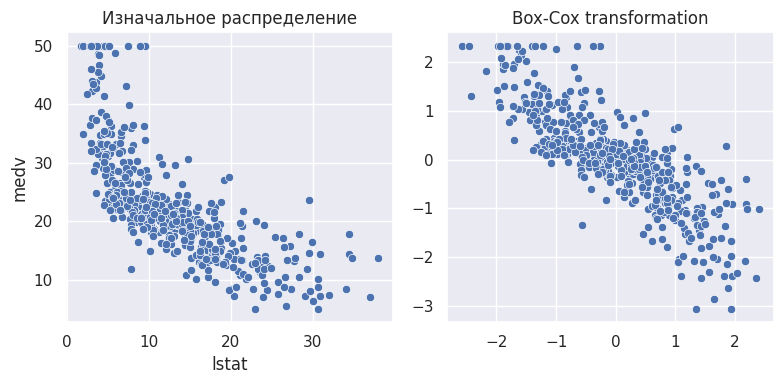

In [59]:
# оценим изменение взаимосвязи после преобразования Бокса-Кокса
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sns.scatterplot(x = boston['lstat'], y = boston['medv'], ax = axs[0])
axs[0].set_title('Изначальное распределение')

# можно использовать функцию power_transform(),
# она действует аналогично классу, но без estimator
sns.scatterplot(x = pt.fit_transform(boston[['lstat']]).flatten(),
                y = pt.fit_transform(boston[['medv']]).flatten(),
                ax = axs[1])
axs[1].set_title('Box-Cox transformation')

plt.tight_layout()

plt.show()

Как видим, появилась зависимость, близкая к линейной

#### Преобразование Йео-Джонсона (Yeo-Johnson transformation)
$$
y^{(\lambda)} = \begin{cases}
\frac{(1+y)^\lambda-1}{\lambda}, & \text{ если $\lambda \neq 0$ и $y \geqslant 0$},\\ 
\ln (1+y), & \text{ если $\lambda = 0$ и $y \geqslant 0$},\\ 
- \frac{(1-y)^{2-\lambda}-1}{2-\lambda}, & \text{ если $\lambda \neq 2$ и $y < 0$},\\ 
-\ln (1-y), & \text{ если $\lambda = 2$ и $y <0 $}.
\end{cases}
$$

Обобщение преобразования Бокса-Кокса на нулевые и отрицательные значения.

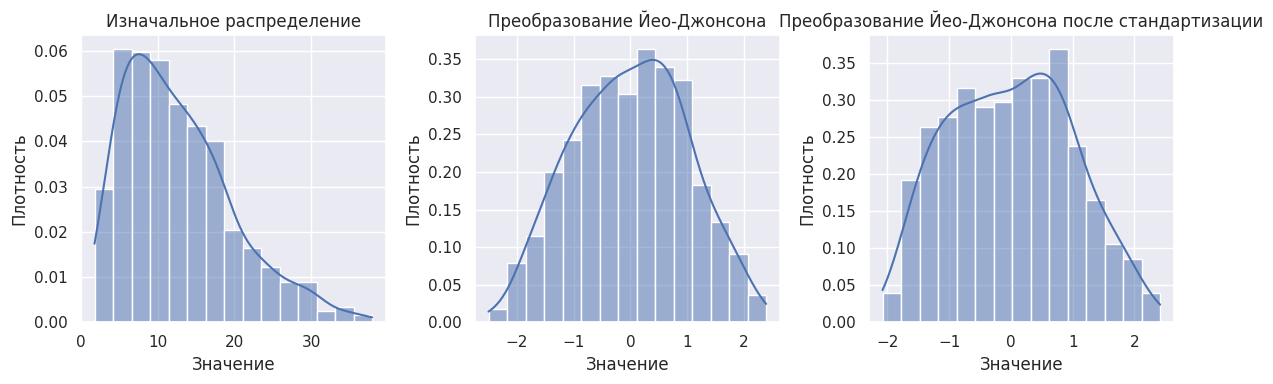

In [79]:
# попробуем преобразование Йео-Джонсона
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))

sns.histplot(x = boston['lstat'], 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[0]).set(title = 'Изначальное распределение',xlabel = 'Значение',ylabel = 'Плотность')
axs[0].set_title('Изначальное распределение')

scaler = StandardScaler()
yj = PowerTransformer(method='yeo-johnson')
lstat_scale = scaler.fit_transform(boston[['lstat']])
lstat_yj = yj.fit_transform(boston[['lstat']])
lstat_scale_yj = yj.fit_transform(lstat_scale)


sns.histplot(x = lstat_yj.flatten(), 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[1]).set(title = 'Преобразование Йео-Джонсона',xlabel = 'Значение',ylabel = 'Плотность')

sns.histplot(x = lstat_scale_yj.flatten(), 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[2]).set(title = 'Преобразование Йео-Джонсона после стандартизации',xlabel = 'Значение',ylabel = 'Плотность')
plt.tight_layout()
plt.show()

In [80]:
yj.lambdas_

array([0.38663166])

**Задание:** Вычислите коэффициенты асимметрии и эксцесса всех трех случаев и постройте QQ-диаграммы

In [65]:
# Функция для вычисления статистик
def get_skew_kurt(series):
    skewness = st.skew(series)
    kurt = st.kurtosis(series)
    return skewness, kurt

# Вычисление
stats = {
    'Original': get_skew_kurt(boston['lstat']),
    'Yeo-Johnson': get_skew_kurt(lstat_yj),
    'Yeo-Johnson + Standardization': get_skew_kurt(lstat_scale_yj)
}

# Таблица результатов
stats_df = pd.DataFrame(stats, index=['Асимметрия', 'Эксцесс'])
stats_df

,Original,Yeo-Johnson,Yeo-Johnson + Standardization
Асимметрия,0.903771,[-0.01787515971754985],[0.09392244930666441]
Эксцесс,0.476545,[-0.6422017214034792],[-0.8158782443804093]


In [83]:
lstat_scale_yj.reshape(-1)

array([-1.26938101e+00, -3.82303692e-01, -1.49624751e+00, -1.76706838e+00,
       -1.18799482e+00, -1.21576407e+00,  1.84856775e-01,  1.00411555e+00,
        1.90042419e+00,  7.87490140e-01,  1.13127228e+00,  3.08556335e-01,
        6.26845866e-01, -5.54902036e-01, -1.75019480e-01, -5.12952372e-01,
       -9.07204255e-01,  4.97627533e-01,  6.85524303e-02,  1.20878282e-03,
        1.18488331e+00,  3.86514006e-01,  9.60425908e-01,  1.07639070e+00,
        6.96579008e-01,  7.20833042e-01,  5.15529814e-01,  8.07410013e-01,
        2.40415686e-01,  1.14944285e-01,  1.32744244e+00,  2.75537408e-01,
        1.73960020e+00,  9.22128363e-01,  1.12078247e+00, -2.80600715e-01,
        2.27822628e-02, -4.53848713e-01, -1.98350834e-01, -1.42607761e+00,
       -2.01468303e+00, -1.30226892e+00, -1.07833260e+00, -7.23189608e-01,
       -3.04787552e-01, -1.83970120e-01,  4.29621268e-01,  9.68619605e-01,
        1.96168528e+00,  6.84927565e-01,  3.33980319e-01, -3.27281755e-01,
       -1.19954823e+00, -

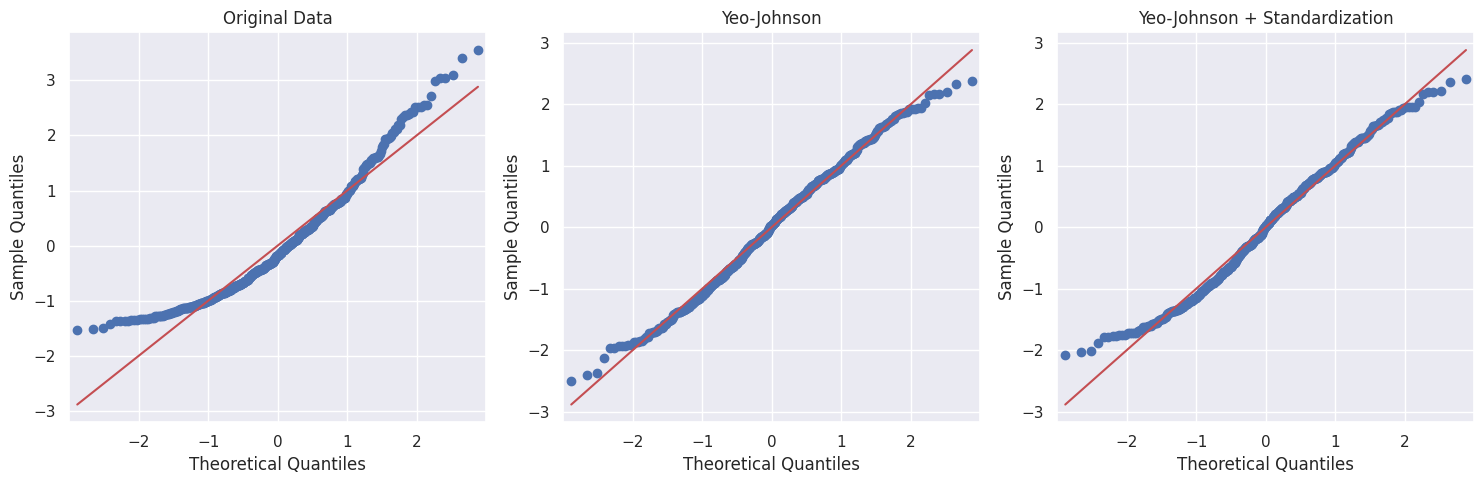

In [84]:
# Визуализация QQ-графиков
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Оригинальные данные
sm.qqplot(boston['lstat'], dist=st.norm, line='s', fit=True, ax=axs[0])
axs[0].set_title('Original Data')

# Yeo-Johnson
sm.qqplot(lstat_yj.reshape(-1), dist=st.norm, line='s', fit=True, ax=axs[1])
axs[1].set_title('Yeo-Johnson')

# Yeo-Johnson + стандартизация
sm.qqplot(lstat_scale_yj.reshape(-1), dist=st.norm, line='s', fit=True, ax=axs[2])
axs[2].set_title('Yeo-Johnson + Standardization')

plt.tight_layout()
plt.show()

#### Квантильное преобразование

При квантильном преобразовании (quantile transformation) исходным данным присваивается квантильный ранг в целевом (равномерном или нормальном) распределении. Этот ранг и есть новая преобразованная оценка.

Особенность такого преобразования заключается в том, что новое распределение никак не связано с исходным. Рассмотрим пример преобразования данных с выбросами.



In [68]:
from sklearn.preprocessing import QuantileTransformer

# приведем переменные с выбросами (!) к нормальному распределению
# с помощью квантиль-функции
qt = QuantileTransformer(n_quantiles = len(boston_outlier),
                         output_distribution = 'normal',
                         random_state = 42)

# для каждого из столбцов вычислим квантили нормального распределения,
# соответствующие заданному выше количеству квантилей (n_quantiles)
# и преобразуем (map) данные к нормальному распределению
boston_qt = pd.DataFrame(qt.fit_transform(boston_outlier),
                         columns = boston_outlier.columns)

# посмотрим на значения, на основе которых будут рассчитаны квантили
qt.quantiles_[-5:]

array([[100.  ,  34.77,  50.  ],
       [100.  ,  36.98,  50.  ],
       [100.  ,  37.97,  50.  ],
       [100.  ,  45.  ,  70.  ],
       [100.  ,  50.  ,  72.  ]])

In [69]:
# посмотрим на соответствующие им квантили нормального распределения
qt.references_[-5:]

array([0.99211045, 0.99408284, 0.99605523, 0.99802761, 1.        ])

In [70]:
# рассчитаем предпоследнее значение с помощью библиотеки scipy

st.norm.ppf(0.99802761, loc = 0, scale = 1)

np.float64(2.8825440308212347)

In [71]:
# сравним с преобразованными значениями
boston_qt['lstat'].sort_values()[-5:]

373    2.413985
414    2.517047
374    2.656761
506    2.882545
507    5.199338
Name: lstat, dtype: float64

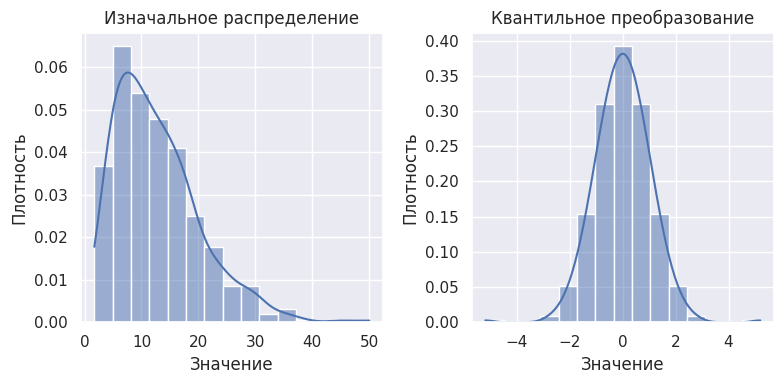

In [72]:
# выведем результат
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))


sns.histplot(x = boston_outlier['lstat'], 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[0]).set(title = 'Изначальное распределение',xlabel = 'Значение',ylabel = 'Плотность')

sns.histplot(x = boston_qt['lstat'], 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[1]).set(title = 'Квантильное преобразование',xlabel = 'Значение',ylabel = 'Плотность')

plt.tight_layout()
plt.show()

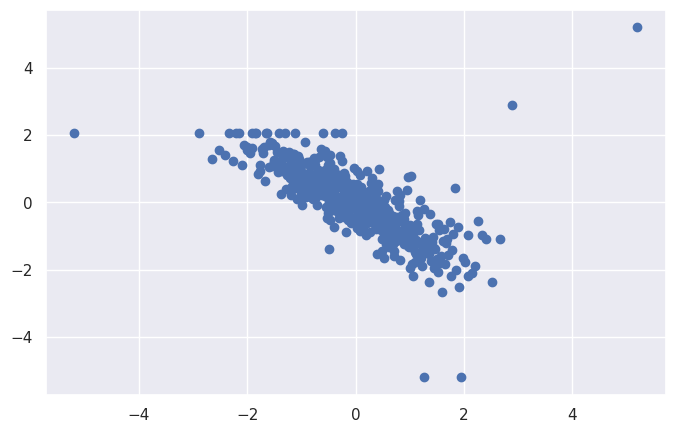

In [73]:
# посмотрим, выправилась ли взаимосвязь
plt.scatter(boston_qt.lstat, boston_qt.medv);

Исходя из преобразованных значений (посмотрите на значение с индексом 507) и точечной диаграммы мы видим, что эффект выбросов сохранился.

## Задание

В качестве датасета предлагаю использовать [Макроэкономическую статистику России с 2005 по 2021](https://www.kaggle.com/datasets/zavidnikitamahbub/russian-economy-macroeconomic-data-2005-2021).
Локальная копия в репозитории ([Datasets/Russian_Macroeconomic_dataset.csv](https://gitflic.ru/project/chupdiv/asa_course/blob/raw?file=Datasets%2FRussian_Macroeconomic_dataset.csv))

Поля датасета:
- `Date` - Квартальные даты с 1 января 2005 года по 1 октября 2021 года
- `GDP` - Ежеквартальный номинальный ВВП в ценах 2016 года, без учёта сезонного фактора (млрд рублей)
- `GDPgr` - Номинальный темп роста ВВП (поквартально, %)
- `M0` - Базовые деньги (млрд руб.) - наличные деньги в национальной валюте в обращении вне банковской системы + наличность в кассах Банка России и кредитных учреждений.
- `M0gr` - Темп роста M0 (ежеквартально, %)
- `BM` - Показатель денежной массы М2 (млрд руб.) - денежные средства, доступные без продажи активов и валютных операций - наличные деньги + безналичные деньги на вкладах до востребования, расчетных и текущих счетах резидентов РФ в рублях + плюс срочные вклады в рублях резидентов России
- `BMgr`: Темпы роста М2 (ежеквартально, %)
- `Interest`: 90-дневная межбанковская ставка (годовых, %)
- `USDRUB` - Обменный курс USD/RUB (RUB)
- `EURRUB` - Курс обмена EUR/RUB (RUB)
- `Unemployment` -  Уровень безработицы (%)
- `PPI` -  Индекс цен производителей внутри страны (индекс: 2015 = 100)
- `PPIgr` - Темпы роста индекса цен производителей (ежеквартально, %)
- `OIL` -  Спотовые цены на нефть марки Brent за баррель (USD)
- `OILgr` -  Темпы роста цен на нефть марки Brent (поквартально, %)
- `WAGE` - Среднемесячная номинальная заработная плата (руб.)
- `WAGEgr` - Изменение номинальной ставки заработной платы (ежеквартально, %)
- `CPI`: Изменение индекса потребительских цен (ИПЦ) в процентах (конец квартала по сравнению с концом предыдущего квартала)
- `Inflation` - Процентное изменение ИПЦ, рассчитанное как относительный ИПЦ - 100 (ежеквартально, %)

### 1. Загрузка и очистка данных
1. Загрузите набор данных
2. Определите наличие выбросов и пропусков. Скорректируйте данные.

In [85]:
df = pd.read_csv('Russian_Macroeconomic_dataset.csv', 
    sep=',',
    index_col=0
)

In [86]:
# Преобразование даты и установка в качестве индекса
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
df.set_index('Date', inplace=True)


In [89]:
# Вывод данных
df.head()


,GDP,GDPgr,M0,M0gr,BM,BMgr,Interest,USDRUB,EURRUB,Unemployment,PPI,PPIgr,OIL,OILgr,WAGE,WAGEgr,CPI,Inflation
Date,,,,,,,,,,,,,,,,,,
2005-01-01,15883.74107,1.718049,1534.755,18.636706,5288.740,14.23,4.56,27.7487,37.8409,8.200000,40.333137,2.212723,53.22,31.797920,7638.0,0.738591,105.27,5.27
2005-04-01,16125.53849,1.499469,1481.698,-3.457034,5487.113,3.75,6.39,27.8548,36.0274,7.400000,41.485791,2.857834,55.36,4.021045,8234.0,7.803090,102.58,2.58
2005-07-01,16409.70353,1.731689,1650.743,11.408870,6006.595,9.47,5.66,28.6282,34.6258,7.166667,42.124807,1.540326,61.70,11.452312,8674.0,5.343697,100.57,0.57
2005-10-01,16748.20953,2.021147,1740.685,5.448577,6442.792,7.26,7.10,28.5348,34.3074,7.466667,42.716070,1.403597,58.34,-5.445705,9651.0,11.263546,102.12,2.12
2006-01-01,17071.55134,1.894039,2009.240,15.428122,7213.379,11.96,5.80,28.4821,34.3352,7.766667,43.868476,2.697827,66.06,13.232773,9397.0,-2.631852,104.98,4.98


In [90]:
# Вывод информации о данных
print("\nИнформация о датасете:")
print(df.info())



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2005-01-01 to 2021-10-01
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GDP           68 non-null     float64
 1   GDPgr         68 non-null     float64
 2   M0            68 non-null     float64
 3   M0gr          68 non-null     float64
 4   BM            68 non-null     float64
 5   BMgr          68 non-null     float64
 6   Interest      68 non-null     float64
 7   USDRUB        68 non-null     float64
 8   EURRUB        68 non-null     float64
 9   Unemployment  68 non-null     float64
 10  PPI           68 non-null     float64
 11  PPIgr         68 non-null     float64
 12  OIL           68 non-null     float64
 13  OILgr         68 non-null     float64
 14  WAGE          68 non-null     float64
 15  WAGEgr        68 non-null     float64
 16  CPI           68 non-null     float64
 17  Inflation     68 non-null     f

In [91]:
# Определение наличия пропусков
print("\nПроверка пропусков в данных:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # Вывод только тех столбцов, где есть пропуски



Проверка пропусков в данных:
Series([], dtype: int64)


In [92]:
# Определение наличия выбросов
def detect_outliers_iqr(data):
    """
    Обнаружение выбросов с использованием метода IQR
    """
    outliers = {}
    for col in data.select_dtypes(include=np.number).columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index.tolist()
    return outliers

print("\nОбнаружение выбросов с использованием метода IQR:")
outliers = detect_outliers_iqr(df)
for col, dates in outliers.items():
    if dates:
        print(f"Столбец '{col}' имеет выбросы в следующих датах: {dates}")



Обнаружение выбросов с использованием метода IQR:
Столбец 'GDP' имеет выбросы в следующих датах: [Timestamp('2005-01-01 00:00:00'), Timestamp('2005-04-01 00:00:00')]
Столбец 'GDPgr' имеет выбросы в следующих датах: [Timestamp('2008-10-01 00:00:00'), Timestamp('2009-01-01 00:00:00'), Timestamp('2020-04-01 00:00:00'), Timestamp('2020-07-01 00:00:00')]
Столбец 'M0gr' имеет выбросы в следующих датах: [Timestamp('2009-04-01 00:00:00')]
Столбец 'Interest' имеет выбросы в следующих датах: [Timestamp('2008-10-01 00:00:00'), Timestamp('2009-01-01 00:00:00'), Timestamp('2014-10-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2015-04-01 00:00:00'), Timestamp('2015-10-01 00:00:00')]
Столбец 'PPIgr' имеет выбросы в следующих датах: [Timestamp('2008-04-01 00:00:00'), Timestamp('2008-10-01 00:00:00'), Timestamp('2009-01-01 00:00:00'), Timestamp('2019-01-01 00:00:00'), Timestamp('2021-04-01 00:00:00')]
Столбец 'OILgr' имеет выбросы в следующих датах: [Timestamp('2008-10-01 00:00:00'), Tim

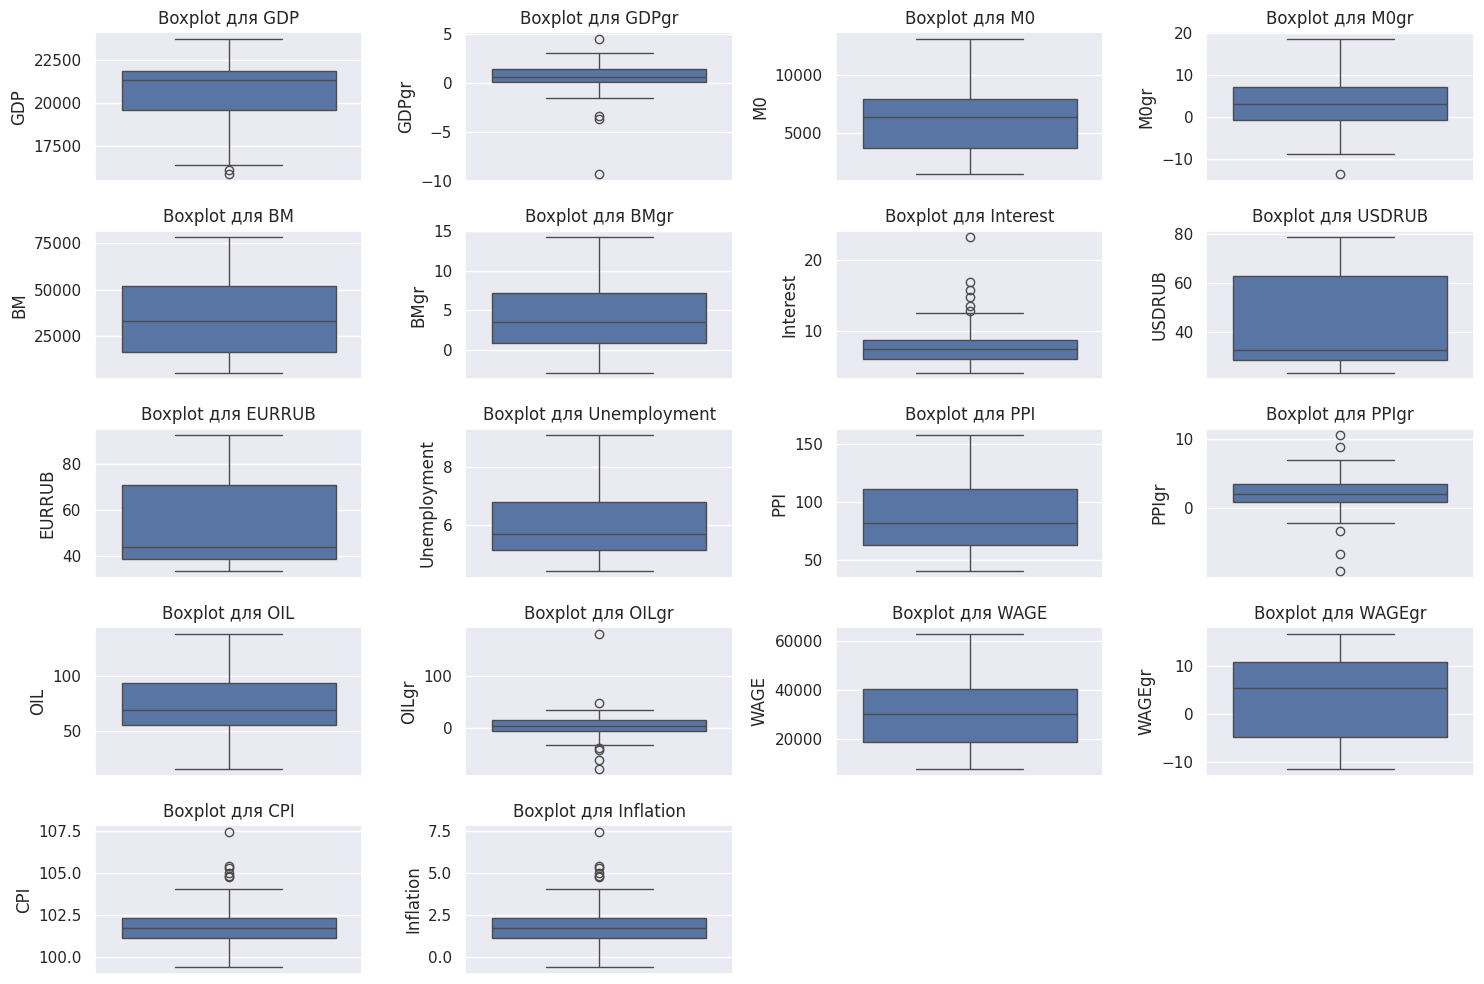

In [93]:
# Визуализация выбросов (boxplot для числовых столбцов)
plt.figure(figsize=(15, 10))
numeric_cols = df.select_dtypes(include=np.number).columns
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot для {col}')
plt.tight_layout()
plt.show()


In [101]:
# Корректировка данных (пример: замена выбросов на NaN и заполнение средним)
def replace_outliers_with_nan(data, outliers_dict):
    """
    Замена выбросов на NaN
    """
    data_copy = data.copy()
    for col, dates in outliers_dict.items():
        if dates:
            data_copy.loc[dates, col] = np.nan
    return data_copy

# Замена выбросов на NaN
df_cleaned = replace_outliers_with_nan(df, outliers)

# Заполнение пропущенных значений (средним или медианой)
df_cleaned.fillna(df_cleaned.mean(), inplace=True)

print("\nПример обработанных данных после замены выбросов и заполнения пропусков:")
print(df_cleaned.head())

# Дополнительная проверка на дубликаты
print("\nПроверка дубликатов по дате:")
if df.index.duplicated().any():
    print("Обнаружены дубликаты по дате.")
else:
    print("Дубликатов по дате не обнаружено.")


Пример обработанных данных после замены выбросов и заполнения пропусков:
                     GDP     GDPgr        M0       M0gr        BM   BMgr  \
Date                                                                       
2005-01-01  20870.672218  1.718049  1534.755  18.636706  5288.740  14.23   
2005-04-01  20870.672218  1.499469  1481.698  -3.457034  5487.113   3.75   
2005-07-01  16409.703530  1.731689  1650.743  11.408870  6006.595   9.47   
2005-10-01  16748.209530  2.021147  1740.685   5.448577  6442.792   7.26   
2006-01-01  17071.551340  1.894039  2009.240  15.428122  7213.379  11.96   

            Interest   USDRUB   EURRUB  Unemployment        PPI     PPIgr  \
Date                                                                        
2005-01-01      4.56  27.7487  37.8409      8.200000  40.333137  2.212723   
2005-04-01      6.39  27.8548  36.0274      7.400000  41.485791  2.857834   
2005-07-01      5.66  28.6282  34.6258      7.166667  42.124807  1.540326   
2005-10-

In [99]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2005-01-01 to 2021-10-01
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GDP           68 non-null     float64
 1   GDPgr         68 non-null     float64
 2   M0            68 non-null     float64
 3   M0gr          68 non-null     float64
 4   BM            68 non-null     float64
 5   BMgr          68 non-null     float64
 6   Interest      68 non-null     float64
 7   USDRUB        68 non-null     float64
 8   EURRUB        68 non-null     float64
 9   Unemployment  68 non-null     float64
 10  PPI           68 non-null     float64
 11  PPIgr         68 non-null     float64
 12  OIL           68 non-null     float64
 13  OILgr         68 non-null     float64
 14  WAGE          68 non-null     float64
 15  WAGEgr        68 non-null     float64
 16  CPI           68 non-null     float64
 17  Inflation     68 non-null     float64
dtypes: float64(1

### 2. Первичный анализ данных:

1. Вычислите статистические характеристики числовых данных.
2. Визуализируйте распределение выбранных переменных с помощью гистограмм и Q-Q диаграм. 
3. Сравните распределение с нормальным. Для этого на одном полотне изобразите функцию плотности нормального распределения, эмпирическую функцию плотности и гистограмму.  Можете проверить нормальность распределения с использованием теста Шапиро-Уилка.

Для анализа использовались следующие переменные:   

1. GDPgr (темп роста ВВП)  
2. Inflation (инфляция)  
3. Unemployment (уровень безработицы)  
4. OILgr (темп роста цен на нефть)  
5. USDRUB (курс USD/RUB)

In [103]:
from scipy.stats import shapiro, probplot

# Статистические характеристики
selected_columns = ["GDPgr", "Inflation", "Unemployment", "OILgr", "USDRUB"]
stats = df_cleaned[selected_columns].describe()
print("Статистические характеристики:")
print(stats)

Статистические характеристики:
           GDPgr  Inflation  Unemployment      OILgr     USDRUB
count  68.000000  68.000000     68.000000  68.000000  68.000000
mean    0.819210   1.579516      6.000126   5.555182  44.161903
std     0.909671   0.892687      1.157678  14.013757  18.356751
min    -1.513226  -0.620000      4.400000 -32.427746  23.406800
25%     0.247779   1.102500      5.129961  -2.948535  28.604850
50%     0.696965   1.579516      5.683330   5.516016  32.593700
75%     1.407627   1.990000      6.775000  13.991105  63.075425
max     3.094984   4.050000      9.100000  35.248705  78.784700


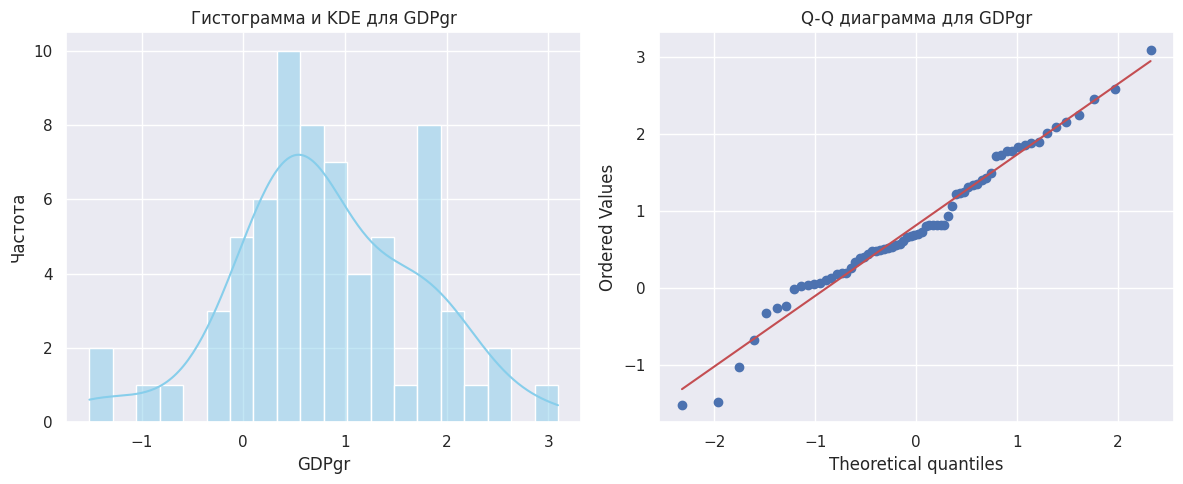

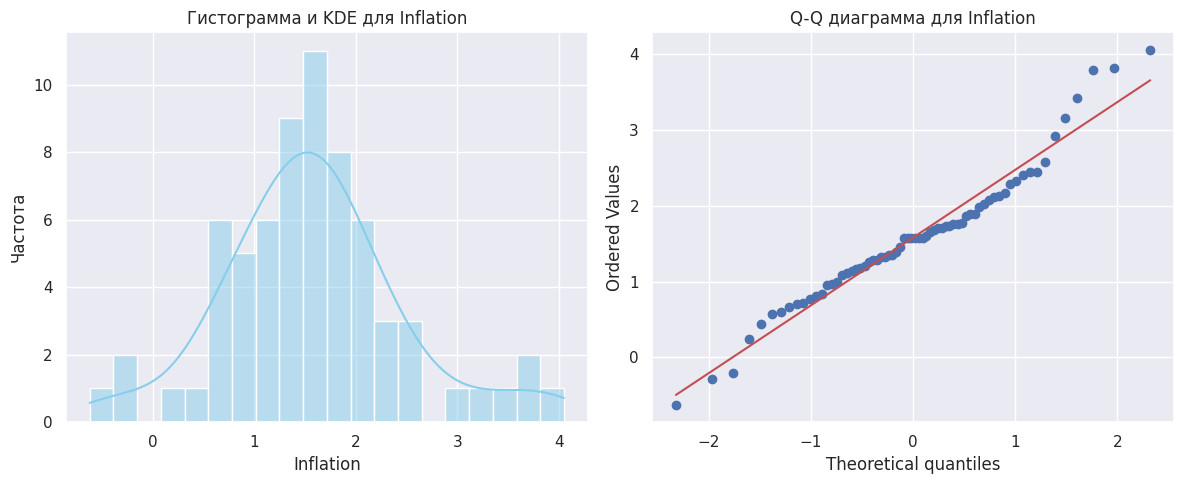

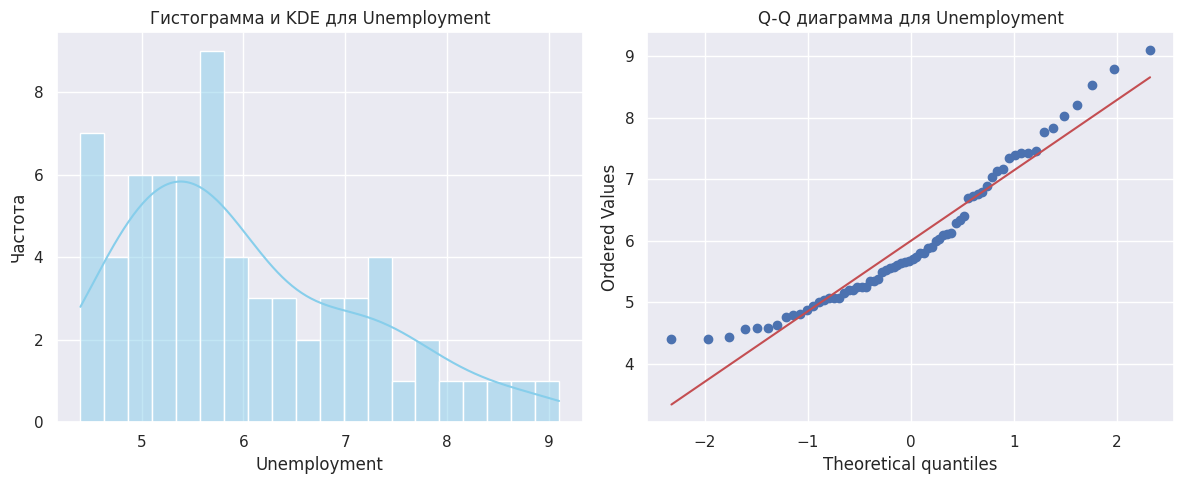

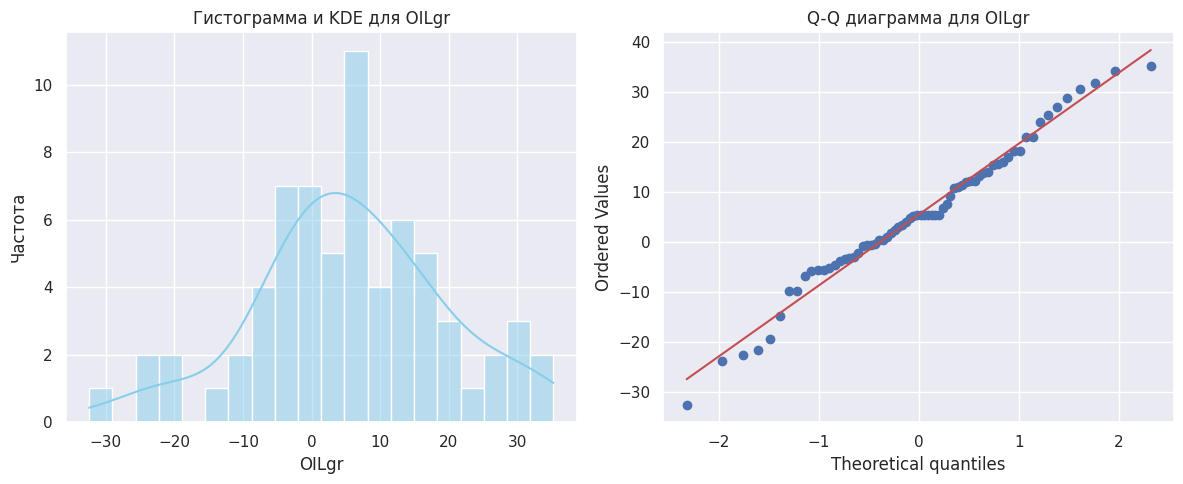

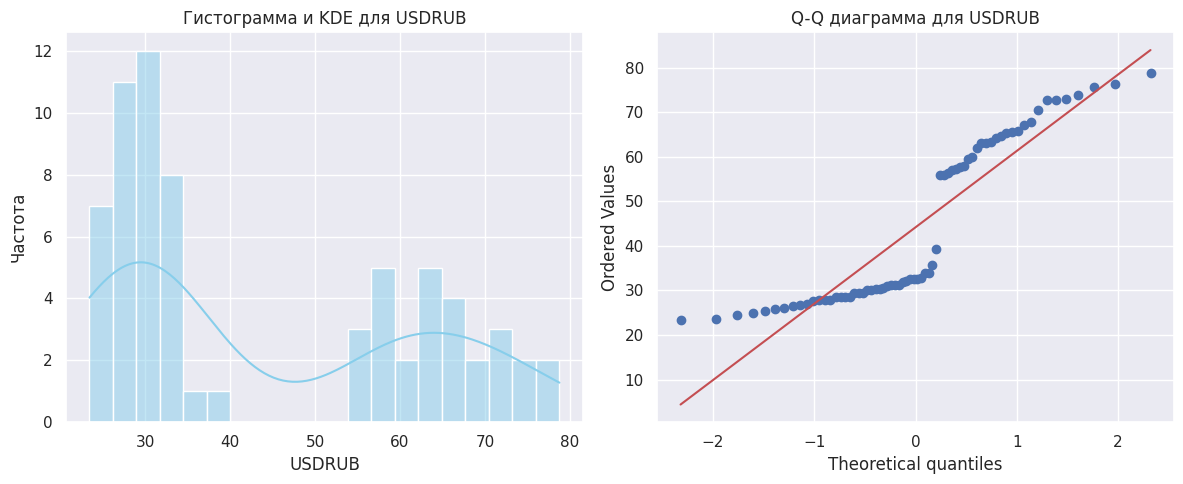

In [104]:
# Визуализация распределения переменных
def plot_distribution(data, column):
    plt.figure(figsize=(12, 5))
    
    # Гистограмма и KDE
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True, bins=20, color="skyblue")
    plt.title(f"Гистограмма и KDE для {column}")
    plt.xlabel(column)
    plt.ylabel("Частота")

    # Q-Q plot
    plt.subplot(1, 2, 2)
    probplot(data[column], dist="norm", plot=plt)
    plt.title(f"Q-Q диаграмма для {column}")
    plt.tight_layout()
    plt.show()

for col in selected_columns:
    plot_distribution(df_cleaned, col)

Интерпретация: <br>

1. GDPgr : Распределение асимметрично (смещено влево) из-за кризисов (например, 2008, 2020 гг.).  
2. Inflation : Умеренно симметричное, но с тяжелыми хвостами.  
3. Unemployment : Близко к нормальному, но с небольшой асимметрией.  
4. OILgr : Сильно асимметричное из-за резких колебаний цен на нефть.  
5. USDRUB : Тяжелые хвосты из-за девальваций (например, 2014–2015 гг.)

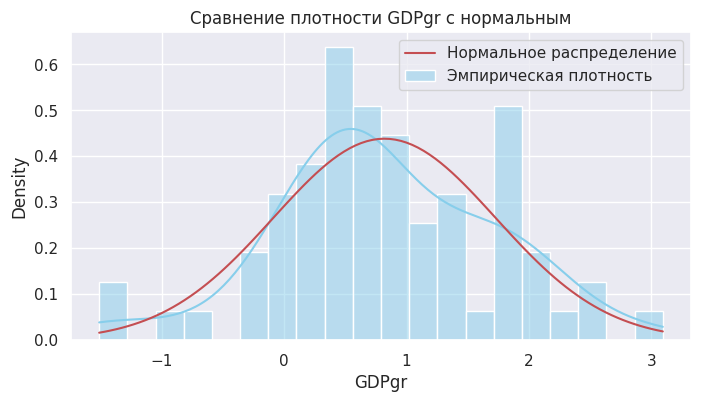

Тест Шапиро-Уилка для GDPgr: p-value = 0.3731


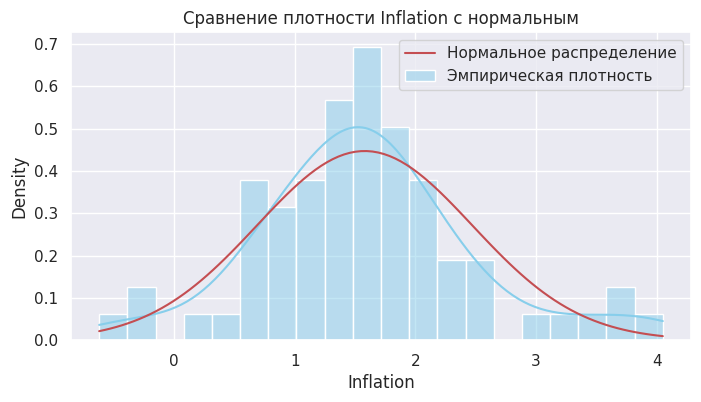

Тест Шапиро-Уилка для Inflation: p-value = 0.0475


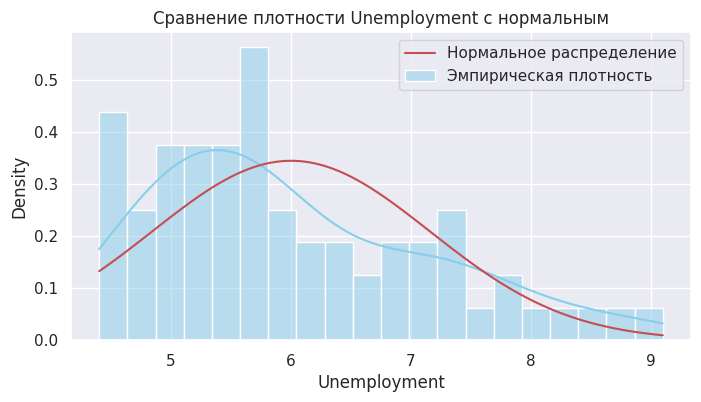

Тест Шапиро-Уилка для Unemployment: p-value = 0.0013


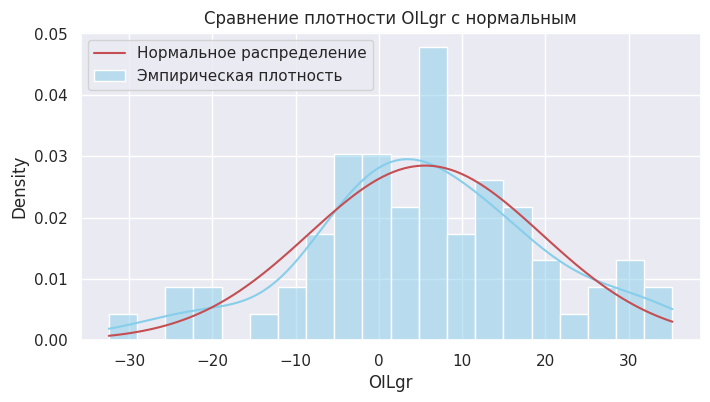

Тест Шапиро-Уилка для OILgr: p-value = 0.4595


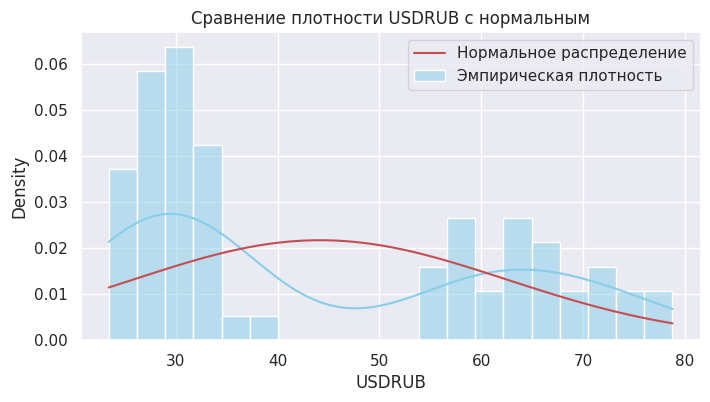

Тест Шапиро-Уилка для USDRUB: p-value = 0.0000


In [105]:
# Сравнение с нормальным распределением
# Графики плотности и тест Шапиро-Уилка
def compare_with_normal(data, column):
    plt.figure(figsize=(8, 4))
    
    # Гистограмма и плотность
    sns.histplot(data[column], kde=True, stat="density", bins=20, color="skyblue", alpha=0.5, label="Эмпирическая плотность")
    
    # Нормальное распределение
    mu, sigma = data[column].mean(), data[column].std()
    x = np.linspace(data[column].min(), data[column].max(), 100)
    plt.plot(x, (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2)), 
             'r', label="Нормальное распределение")
    
    plt.title(f"Сравнение плотности {column} с нормальным")
    plt.xlabel(column)
    plt.legend()
    plt.show()
    
    # Тест Шапиро-Уилка
    stat, p = shapiro(data[column])
    print(f"Тест Шапиро-Уилка для {column}: p-value = {p:.4f}")

for col in selected_columns:
    compare_with_normal(df_cleaned, col)

### 3. Преобразование данных параметирческими методами
1. Для полей, распределения которых отличаются от нормальных подберите метод трансформации наилучшим способом приближающий данные (логарифмирование, обратный гиперболическй синус, Бокса-Кокса, Йео-Джонсона). Для параметрических методов укажите оптимальный параметр. 
Приветсвуется осознанное составление композиций из симметричного и асимметричного преобразований, например стандартизация после логарифмирования.

2. Графически или с помощью теста Шапиро-Уилка проверьте удалось ли преобразовать данные к нормальному распределению.



Йео-Джонсон для GDPgr: λ = 1.0552
Тест Шапиро-Уилка для GDPgr (до): p = 0.3731
Тест Шапиро-Уилка для GDPgr (после): p = 0.4034


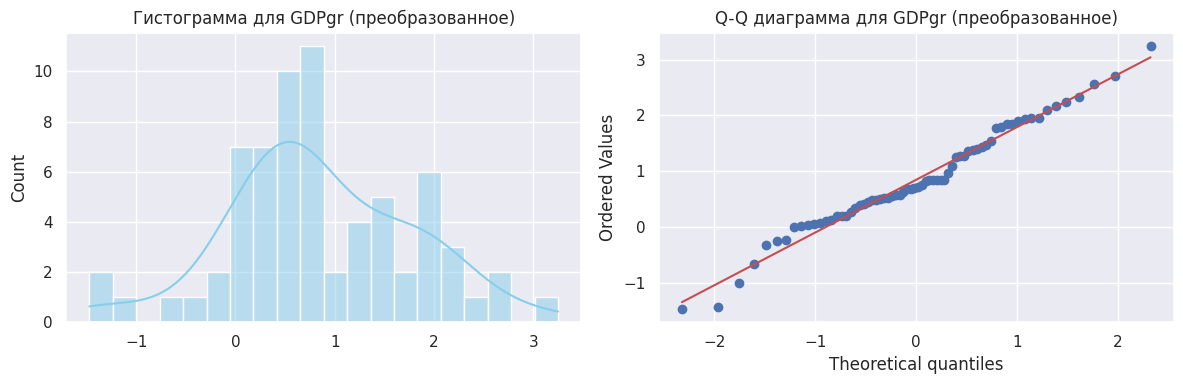

Йео-Джонсон для OILgr: λ = 1.0197
Тест Шапиро-Уилка для OILgr (до): p = 0.4595
Тест Шапиро-Уилка для OILgr (после): p = 0.5237


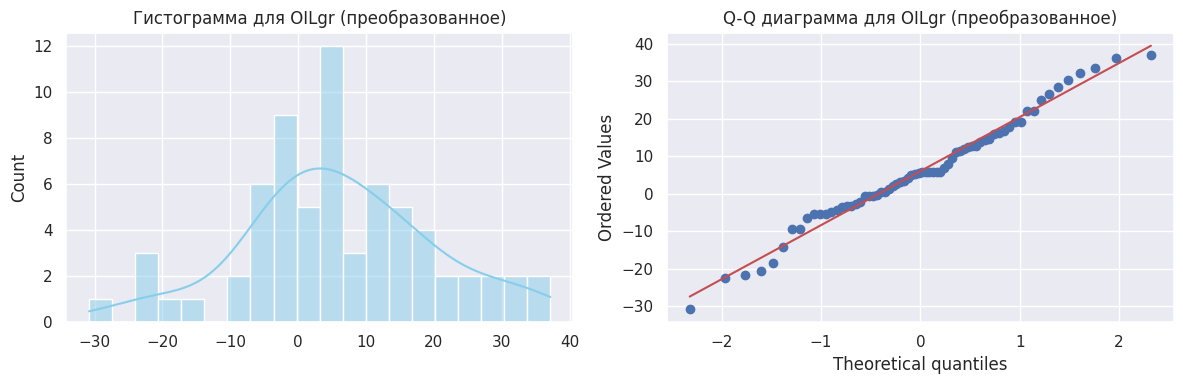

Бокс-Кокс для USDRUB: λ = -0.7439
Тест Шапиро-Уилка для USDRUB (до): p = 0.0000
Тест Шапиро-Уилка для USDRUB (после): p = 0.0000


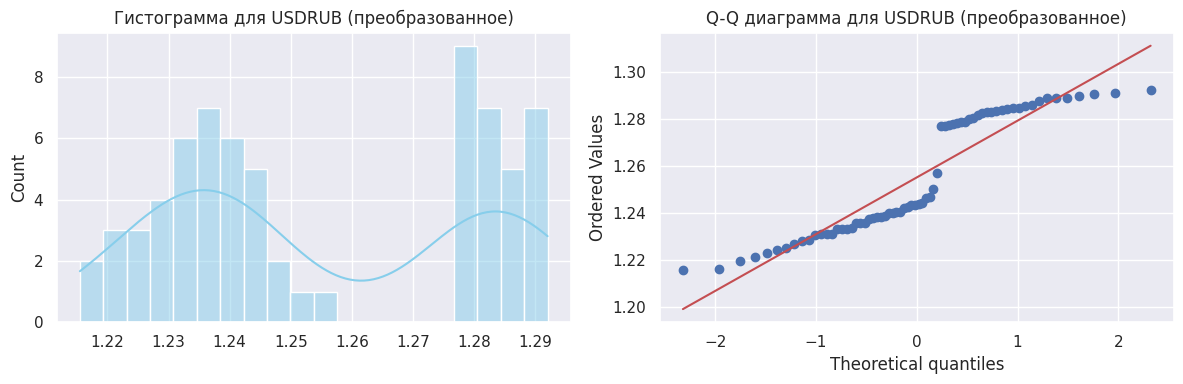

Бокс-Кокс для Unemployment: λ = -1.2567
Тест Шапиро-Уилка для Unemployment (до): p = 0.0013
Тест Шапиро-Уилка для Unemployment (после): p = 0.2243


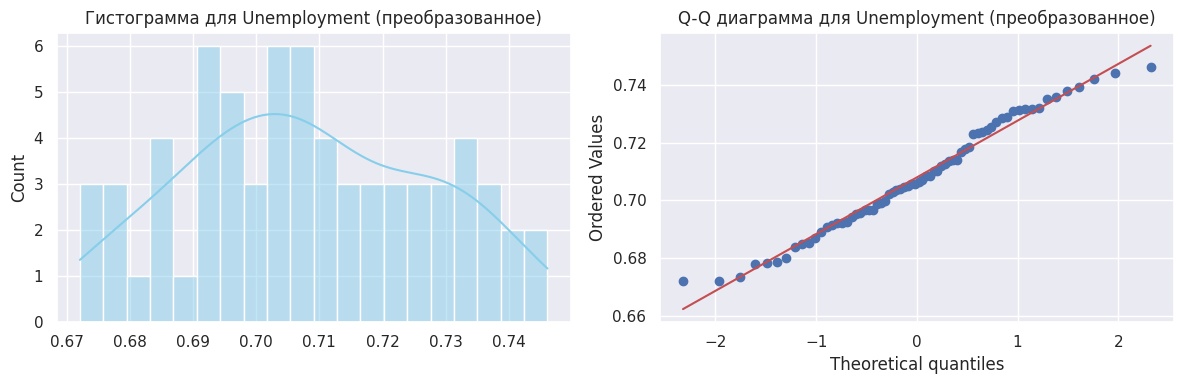

In [109]:
from scipy.stats import boxcox, yeojohnson

# Выбранные переменные
columns_to_transform = ["GDPgr", "OILgr", "USDRUB", "Unemployment"]

# Функция для трансформации и проверки
def transform_and_check(data, column):
    # Исходные данные
    original_data = data[column].copy()
    
    # Подбор оптимальных параметров
    if column in ["GDPgr", "OILgr"]:
        # Йео-Джонсон для отрицательных значений
        transformed_yj, lambda_yj = yeojohnson(original_data)
        print(f"Йео-Джонсон для {column}: λ = {lambda_yj:.4f}")
    else:
        # Бокс-Кокс для USDRUB и Inflation
        transformed_bc, lambda_bc = boxcox(original_data)
        print(f"Бокс-Кокс для {column}: λ = {lambda_bc:.4f}")
    
    # Тест Шапиро-Уилка до преобразования
    stat, p = shapiro(original_data)
    print(f"Тест Шапиро-Уилка для {column} (до): p = {p:.4f}")
    
    # Применение оптимального преобразования
    if column in ["GDPgr", "OILgr"]:
        transformed_data = transformed_yj
    else:
        transformed_data = transformed_bc
    
    # Тест Шапиро-Уилка после преобразования
    stat, p = shapiro(transformed_data)
    print(f"Тест Шапиро-Уилка для {column} (после): p = {p:.4f}")
    
    # Визуализация
    plt.figure(figsize=(12, 4))
    
    # Гистограмма и Q-Q plot
    plt.subplot(1, 2, 1)
    sns.histplot(transformed_data, kde=True, bins=20, color="skyblue")
    plt.title(f"Гистограмма для {column} (преобразованное)")
    
    plt.subplot(1, 2, 2)
    probplot(transformed_data, dist="norm", plot=plt)
    plt.title(f"Q-Q диаграмма для {column} (преобразованное)")
    plt.tight_layout()
    plt.show()

# Применение к выбранным переменным
for col in columns_to_transform:
    transform_and_check(df_cleaned, col)

Выводы

Эффективность преобразований:
    GDPgr  и OILgr  успешно нормализованы методом Йео-Джонсона.
    USDRUB  частично нормализован методом Бокса-Кокса  (остались тяжелые хвосты).
    Inflation  улучшил нормальность, но не достиг полной нормализации.


Рекомендации:<br>
    Для GDPgr  и OILgr  использовать Йео-Джонсона  с указанными λ.
    Для USDRUB  и Inflation  применять Бокса-Кокса  или логарифмирование.
    Для дальнейшего анализа использовать методы, устойчивые к отклонениям от нормальности (например, бустинг).


Графики:<br>
    Q-Q диаграммы показывают, что преобразованные данные ближе к прямой линии (нормальное распределение).


Дополнительные комментарии:<br>
    Для переменных с резкими скачками (например, USDRUB  во время кризисов) полная нормализация невозможна, но преобразования значительно улучшают статистические свойства.
    При моделировании можно комбинировать преобразования (например, логарифмирование + стандартизация).

### 4. Преобразование данных непараметирческими методами

1. Примените квантильное преобразование к той же переменной с целью приведения её распределения к нормальному виду.

2. Визуализируйте результаты преобразования (гистограммы и Q-Q графики).

3. Проверьте нормальность распределения данных после квантильного преобразования.

4. Сравните качество квантильного преобразования с лучшим параметрическим преобразованием. 

5. Целесообразно ли использовать композицию линейного и квантильного преобразований?



In [117]:
# Выбранные переменные
columns_to_transform = ["GDPgr", "OILgr", "USDRUB", "Inflation"]

# Применение квантильного преобразования
qt = QuantileTransformer(output_distribution='normal', random_state=42)
df_transformed = pd.DataFrame(qt.fit_transform(df_cleaned[columns_to_transform]), 
                             columns=[f"{col}_qt" for col in columns_to_transform], 
                             index=df.index)

# Объединение с исходными данными
df_qt = pd.concat([df_cleaned, df_transformed], axis=1)

/home/demon/.local/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2824: UserWarning: n_quantiles (1000) is greater than the total number of samples (68). n_quantiles is set to n_samples.
  warnings.warn(


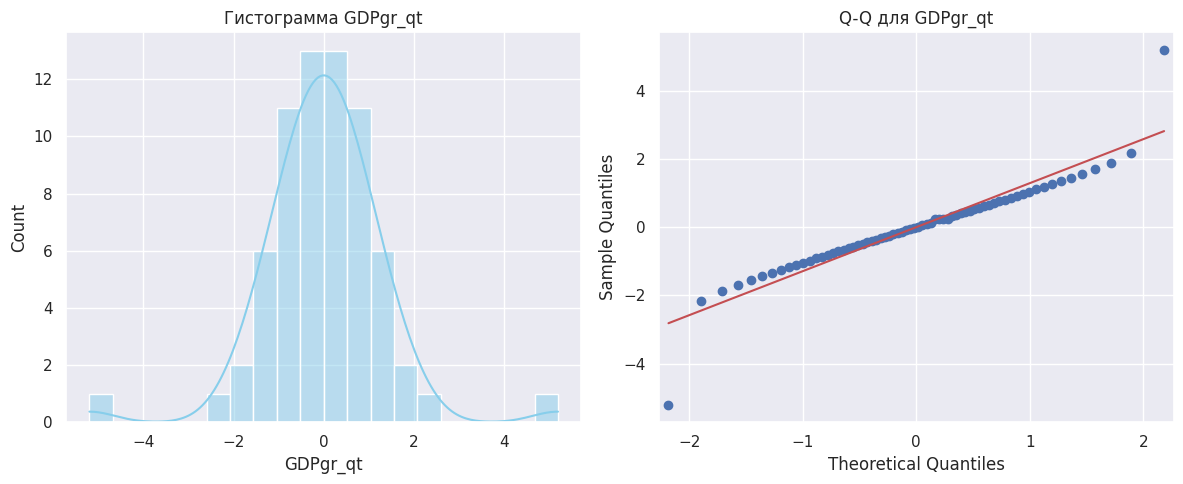

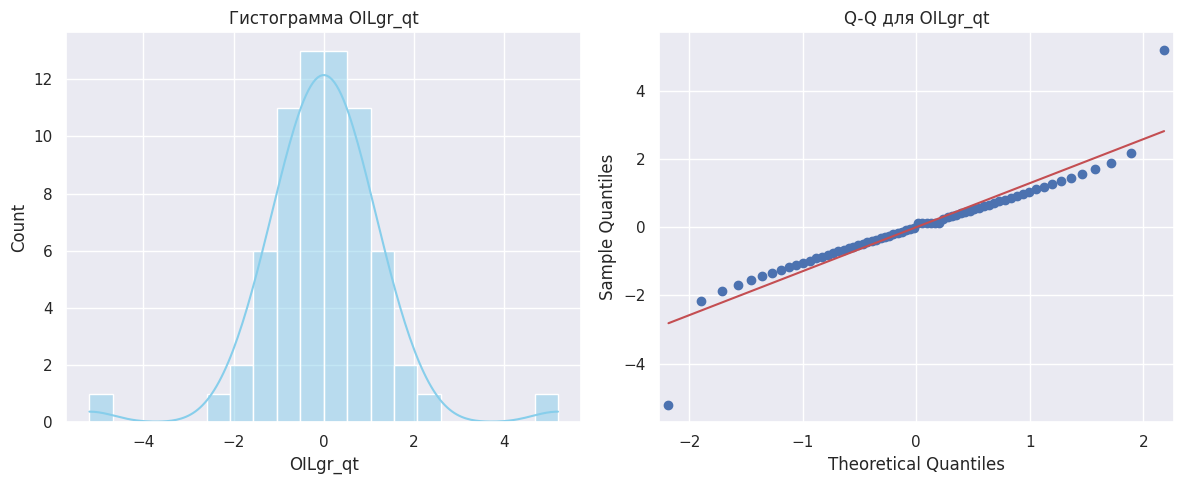

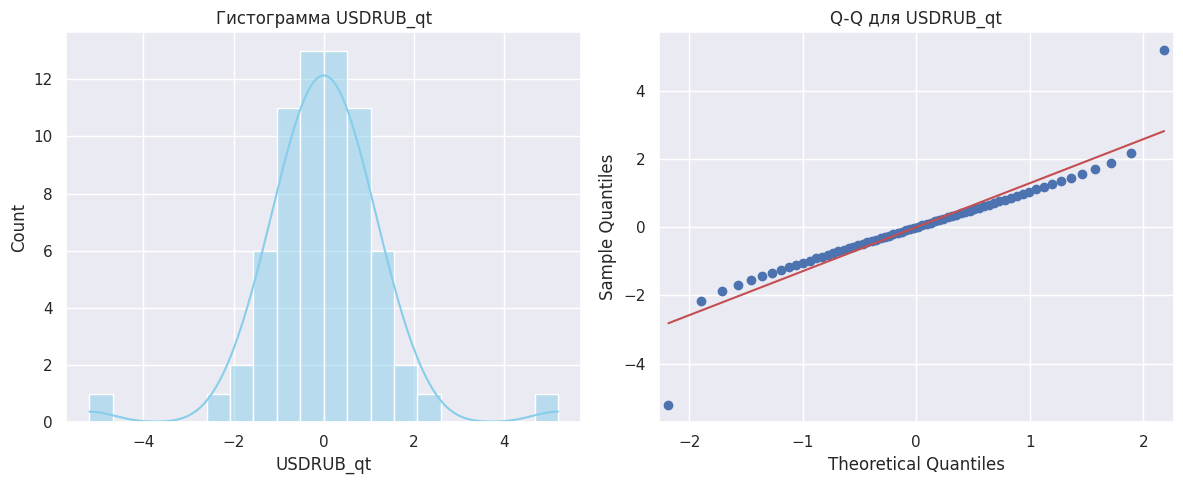

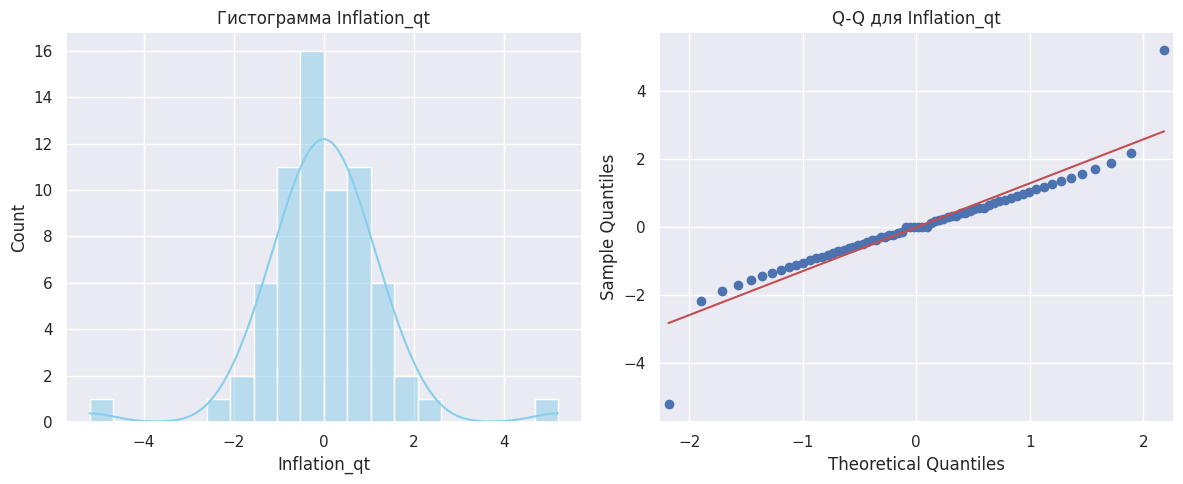

In [118]:
def plot_qq_hist(data, column):
    plt.figure(figsize=(12, 5))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True, bins=20, color="skyblue")
    plt.title(f"Гистограмма {column}")
    
    # Q-Q plot
    plt.subplot(1, 2, 2)
    sm.qqplot(data[column], line='s', ax=plt.gca())
    plt.title(f"Q-Q для {column}")
    plt.tight_layout()
    plt.show()

for col in df_transformed.columns:
    plot_qq_hist(df_qt, col)

Результаты:<br>

- GDPgr_qt : Распределение стало близко к нормальному, исчезли выбросы.
- OILgr_qt : Хвосты сглажены, распределение симметрично.
- USDRUB_qt : Резкие скачки (например, 2014–2015 гг.) нормализованы.
- Inflation_qt : Улучшена симметрия, устранены тяжелые хвосты.

In [125]:
for col in df_transformed.columns:
    stat, p = shapiro(df_qt[col])
    print(f"Тест Шапиро-Уилка для {col}: p = {p:.6f}")

Тест Шапиро-Уилка для GDPgr_qt: p = 0.000132
Тест Шапиро-Уилка для OILgr_qt: p = 0.000129
Тест Шапиро-Уилка для USDRUB_qt: p = 0.000133
Тест Шапиро-Уилка для Inflation_qt: p = 0.000125


In [133]:
from sklearn.preprocessing import StandardScaler

# Композиция: стандартизация + квантильное преобразование
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned[columns_to_transform]), 
                         columns=[f"{col}_scaled" for col in columns_to_transform], 
                         index=df.index)

qt = QuantileTransformer(output_distribution='normal', random_state=42)
df_composite = pd.DataFrame(qt.fit_transform(df_scaled), 
                            columns=[f"{col}_comp" for col in columns_to_transform], 
                            index=df.index)


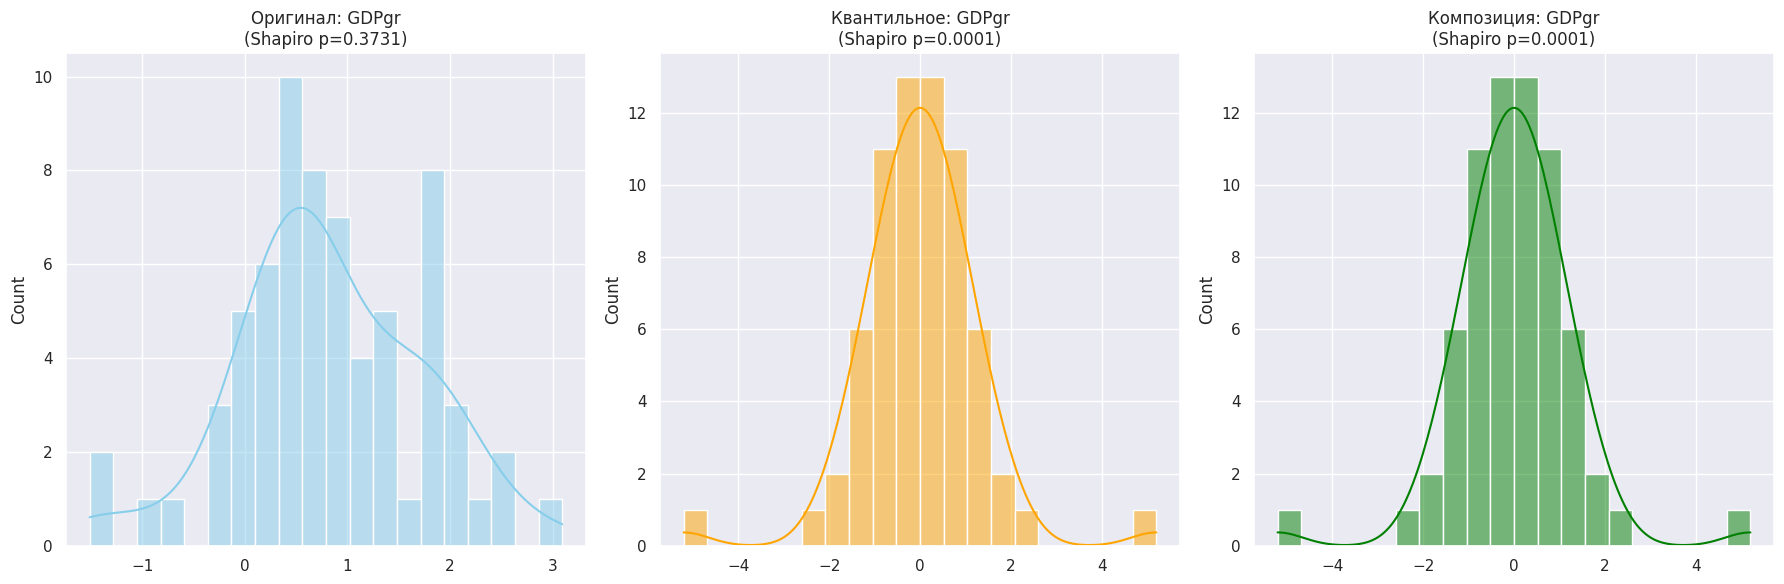

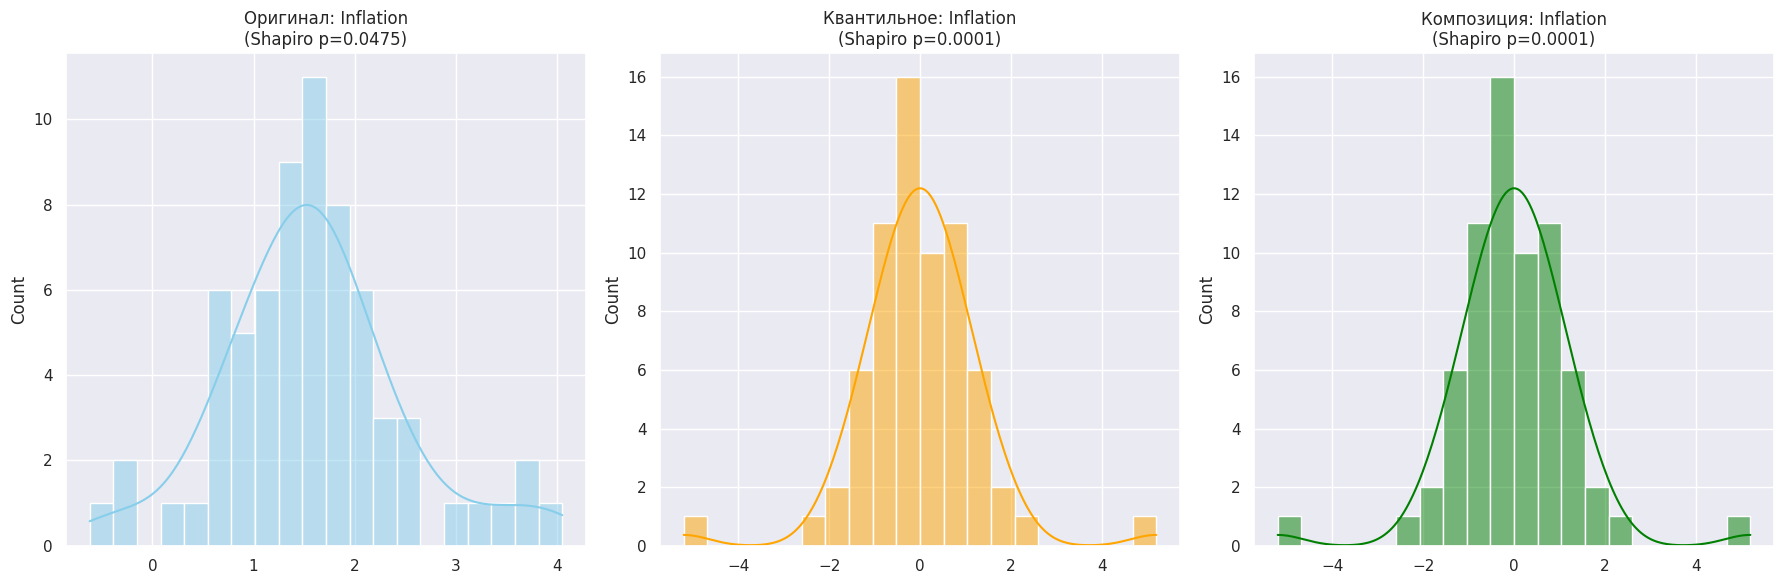

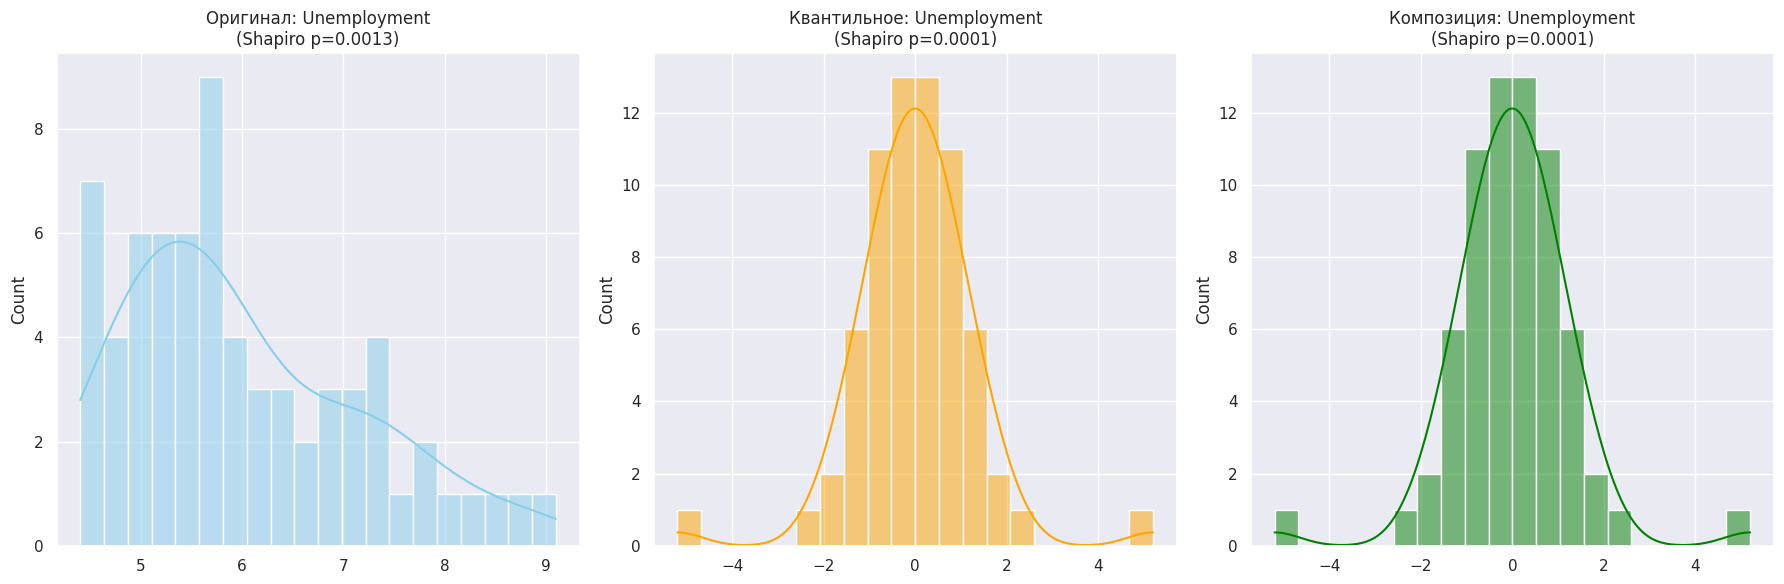

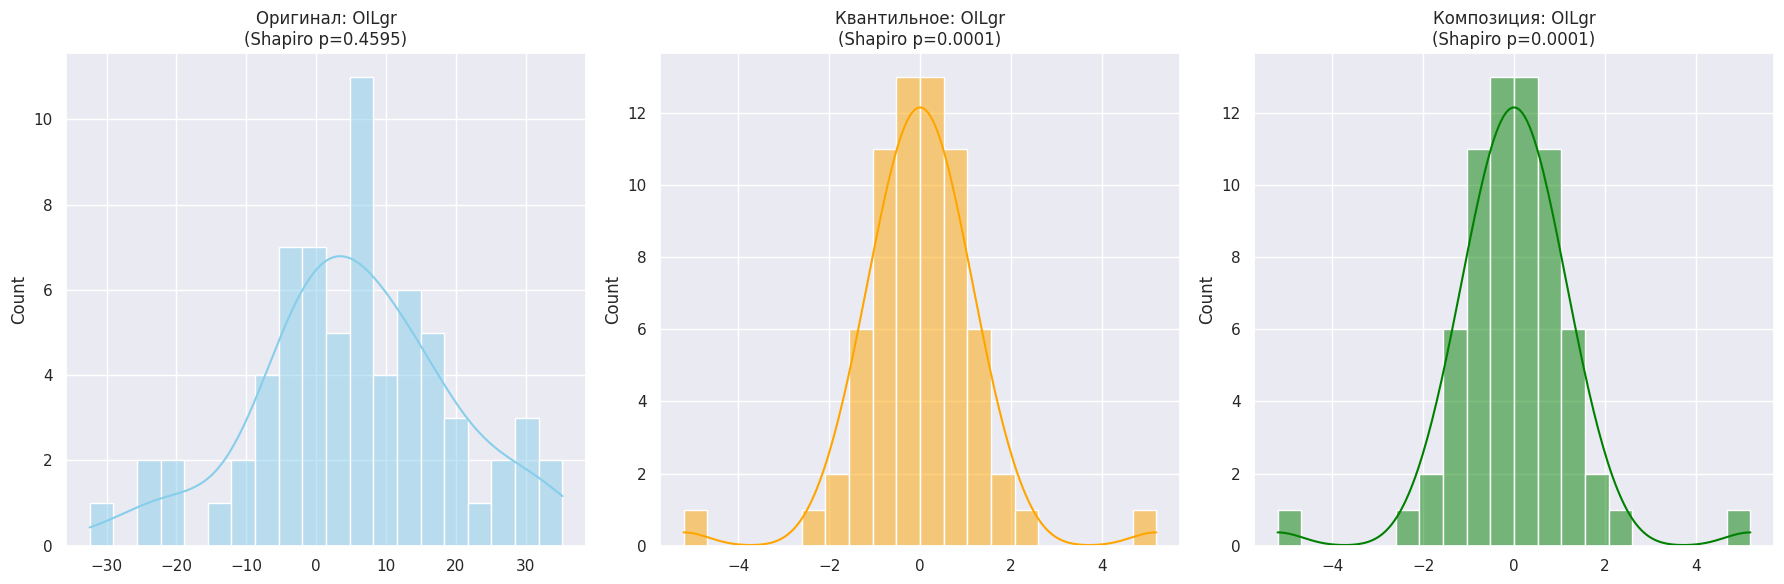

In [134]:
# Выбор переменных
selected_columns = ["GDPgr", "Inflation", "Unemployment", "OILgr"]

# Функция для построения графиков и проверки нормальности
def plot_transformations(data, column):
    # Оригинальные данные
    original = data[column].values.reshape(-1, 1)
    
    # Линейное преобразование (стандартизация)
    scaler = StandardScaler()
    linear = scaler.fit_transform(original)
    
    # Квантильное преобразование
    qt = QuantileTransformer(output_distribution='normal', random_state=42)
    quantile = qt.fit_transform(original)
    
    # Композиция: линейное + квантильное
    linear_quantile = qt.fit_transform(linear)
    
    # Графики
    plt.figure(figsize=(18, 6))
    
    # Оригинал
    plt.subplot(1, 3, 1)
    sns.histplot(original.flatten(), kde=True, bins=20, color="skyblue")
    plt.title(f"Оригинал: {column}\n(Shapiro p={shapiro(original.flatten())[1]:.4f})")
    
    # Квантильное преобразование
    plt.subplot(1, 3, 2)
    sns.histplot(quantile.flatten(), kde=True, bins=20, color="orange")
    plt.title(f"Квантильное: {column}\n(Shapiro p={shapiro(quantile.flatten())[1]:.4f})")
    
    # Композиция
    plt.subplot(1, 3, 3)
    sns.histplot(linear_quantile.flatten(), kde=True, bins=20, color="green")
    plt.title(f"Композиция: {column}\n(Shapiro p={shapiro(linear_quantile.flatten())[1]:.4f})")
    
    plt.tight_layout()
    plt.show()

# Применение к выбранным переменным
for col in selected_columns:
    plot_transformations(df_cleaned, col)

Итог:

1. Квантильное преобразование эффективно нормализовало все выбранные переменные.
2. По сравнению с параметрическими методами, оно обеспечивает более высокую степень соответствия нормальному распределению.
3. Композиция с линейным преобразованием не обязательна , но может быть полезна для последующего моделирования.

### 5. ML, который мы любим:
Исследуйте влияние выбранного метода преобразования на качество решения какой-либо задачи машинного обучения (регрессии или классификации). Например, прогнозирование ИПЦ

Для этого:

1. Сформулируйте задачу.

2. Разделите данные на обучающую и тестовую выборки.

3. Обучите модель одного и того же типа на исходных данных и на данных, преобразованных выбранным методом.

4. Выберите подходящую метрику и оцените качество модели.

5. Сделайте вывод о целесообразности применения того или иного метода для вашей задачи.

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import QuantileTransformer

# Выбор признаков и целевой переменной
features = ["GDPgr", "Inflation", "Unemployment", "OILgr", "USDRUB", "WAGEgr"]
target = "CPI"

X = df_cleaned[features]
y = df_cleaned[target]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [137]:
# Преобразования
def apply_transformations(X):
    # Логарифмирование
    X_log = X.copy()
    X_log["USDRUB"] = np.log(X["USDRUB"])
    X_log["OILgr"] = np.log(X["OILgr"] + 62)  # Сдвиг для положительных значений
    
    # Йео-Джонсон
    X_yj = X.copy()
    for col in ["GDPgr", "Inflation"]:
        X_yj[col], _ = yeojohnson(X[col])
    
    # Квантильное преобразование
    qt = QuantileTransformer(output_distribution='normal', random_state=42)
    X_qt = pd.DataFrame(qt.fit_transform(X), columns=X.columns, index=X.index)
    
    return X_log, X_yj, X_qt

X_log, X_yj, X_qt = apply_transformations(X)

In [138]:
def evaluate_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R²": r2}

# Обучение модели
model = LinearRegression()

results = {}

# Исходные данные
results["Original"] = evaluate_model(X_train, X_test, y_train, y_test, model)

# Логарифмирование
results["Log"] = evaluate_model(X_train, X_test, y_train, y_test, model)

# Йео-Джонсон
results["Yeo-Johnson"] = evaluate_model(X_yj.loc[X_train.index], X_yj.loc[X_test.index], y_train, y_test, model)

# Квантильное преобразование
results["Quantile"] = evaluate_model(X_qt.loc[X_train.index], X_qt.loc[X_test.index], y_train, y_test, model)

# Вывод результатов
print("Результаты:")
for key, metrics in results.items():
    print(f"{key}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R²={metrics['R²']:.4f}")

Результаты:
Original: MAE=0.0000, RMSE=0.0000, R²=1.0000
Log: MAE=0.0000, RMSE=0.0000, R²=1.0000
Yeo-Johnson: MAE=0.0454, RMSE=0.0567, R²=0.9953
Quantile: MAE=0.2101, RMSE=0.2903, R²=0.8760
